## Let's look at the DAMPE data and perform some preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils import get_input_data, prepare_data

In [3]:
calorimeter_images, calorimeter_data, data_target, data_rec = get_input_data()

In [4]:
n_samples, height, width, channels = calorimeter_images.shape
print(f'There are {n_samples} images, each image is {height} pixels by {width} pixels with {channels} channels.')
print(f'The data is of type {calorimeter_images.dtype}')
print(f'The max data entry is {calorimeter_images.max()} the minimum data entry is {calorimeter_images.min()}.')

There are 141946 images, each image is 14 pixels by 22 pixels with 1 channels.
The data is of type float32
The max data entry is 255.0 the minimum data entry is 0.0.


## Understanding the data structure:

>The STK is followed by an imaging calorimeter of about 31 radiation lengths thickness, made up of 14 layers of Bismuth Germanium Oxide (BGO) bars in a hodoscopic arrangement. A layer of neutron detectors is added to the bottom of the calorimeter. [1]

Each image is 14 x 22 pixels; thus each row of pixels is a layer and each column is a readout channel. We can separate out the XY and XZ component of the images, however, let us keep the XZ and XY projections intact and feed it to the network.

Now, let's look at some of the images.

In [5]:
N_LAYERS = 14 # number of BGO layers
N_CHANNELS = 22 # number of readout channels

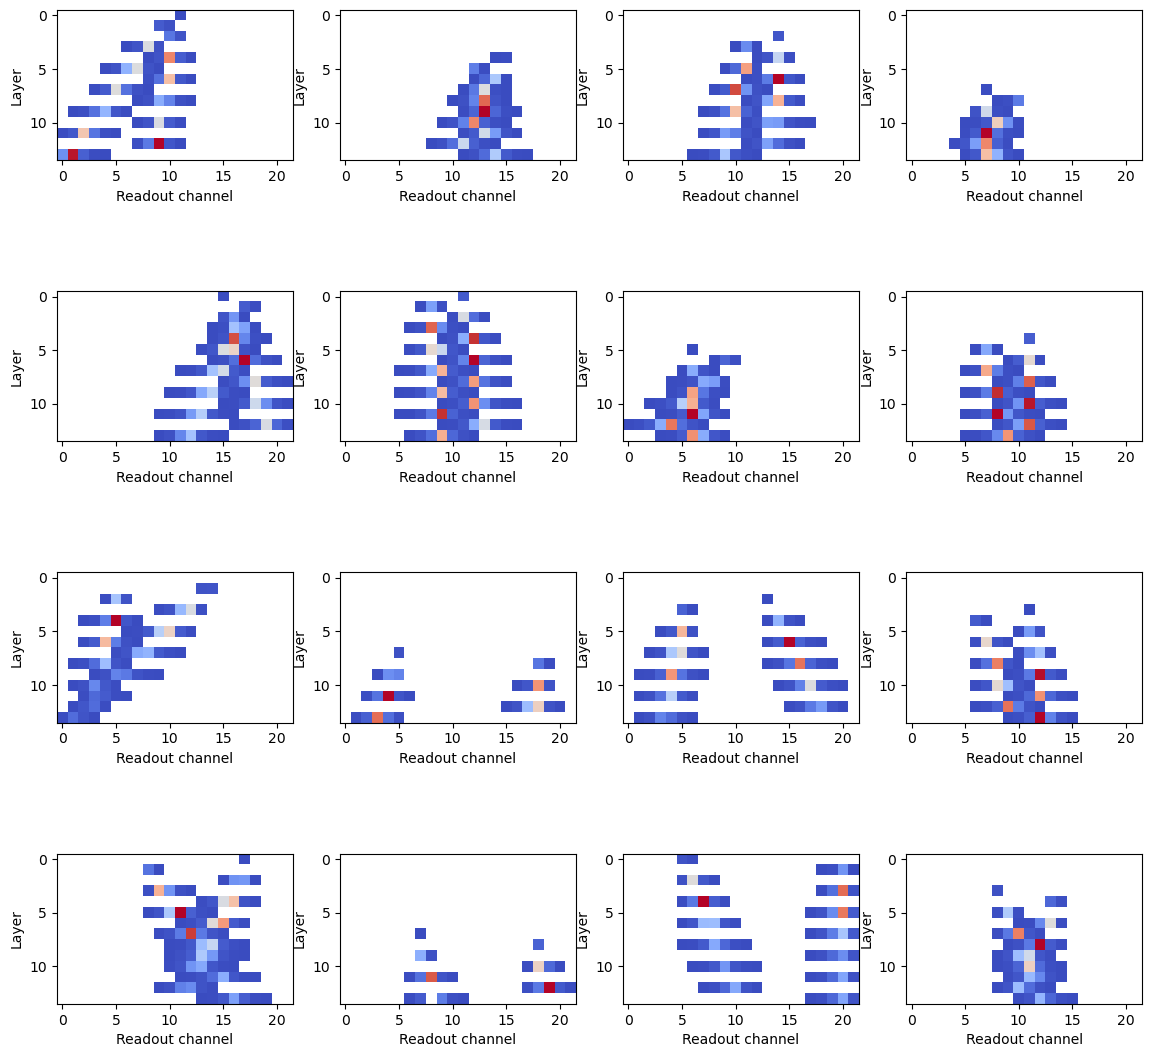

In [6]:
n_c = 4
n_r = 4
fig, ax = plt.subplots(n_c, n_r, figsize=(14, 14))
for i, ax in enumerate(fig.axes):
    # Here we make a copy so we can manipulate the array without changing it in calorimeter_images
    image = calorimeter_images[i].copy()
    # Filling the zero values with NaNs will show us white space where there is zero deposits recorded.
    # Note that if we didn't have the copy there, this would insert NaNs into calorimeter_images.
    image[image == 0] = 'nan'
    ax.imshow(image[:,:,0], cmap="coolwarm")
    ax.set_xlabel("Readout channel")
    ax.set_ylabel("Layer")
plt.show()

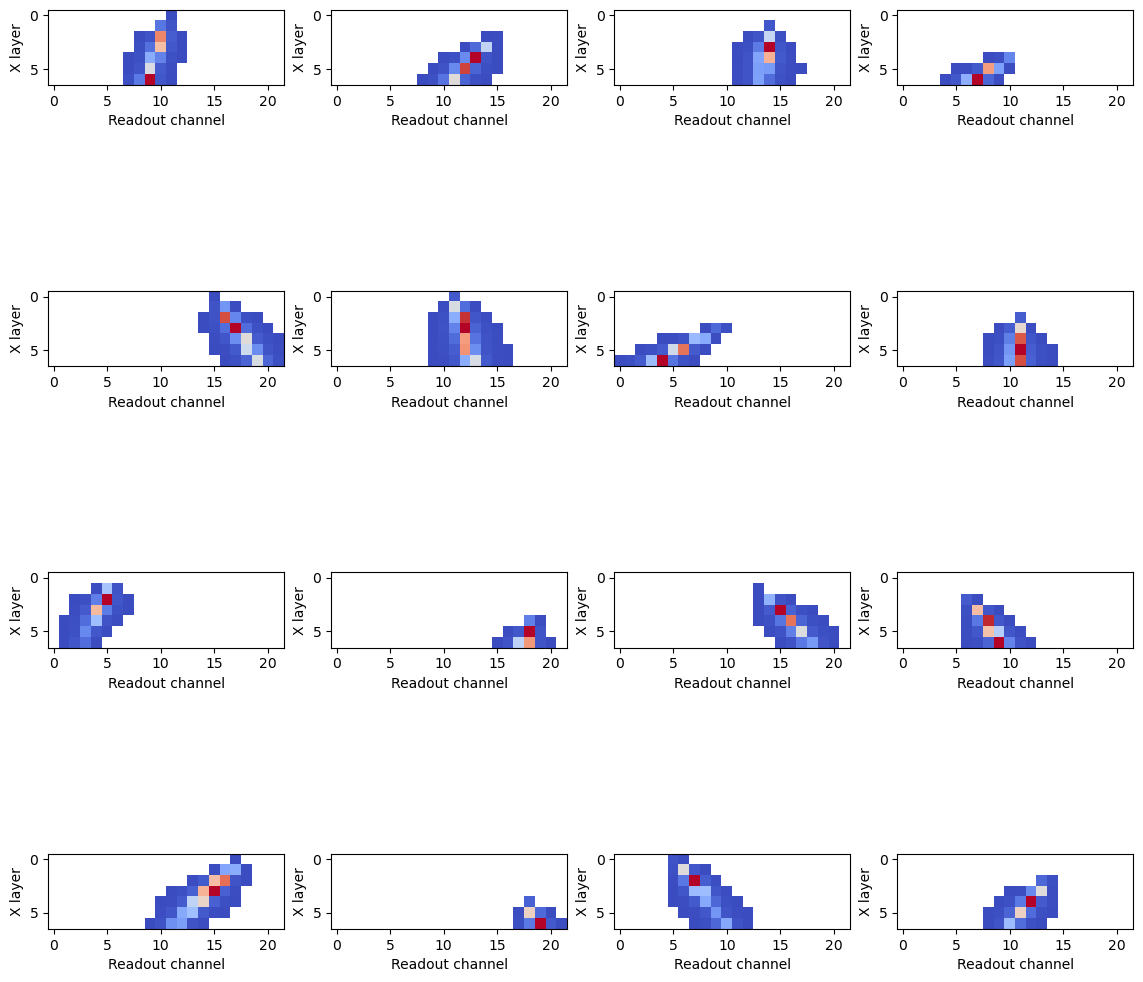

In [7]:
n_c = 4
n_r = 4
fig, ax = plt.subplots(n_c, n_r, figsize=(14, 14))
for i, ax in enumerate(fig.axes):
    # Here we make a copy so we can manipulate the array without changing it in calorimeter_images
    image = calorimeter_images[i].copy()
    # Filling the zero values with NaNs will show us white space where there is zero deposits recorded.
    # Note that if we didn't have the copy there, this would insert NaNs into calorimeter_images.
    image[image == 0] = 'nan'
    ax.imshow(image[0:14:2,:,0], cmap="coolwarm")
    ax.set_xlabel("Readout channel")
    ax.set_ylabel("X layer")
plt.show()

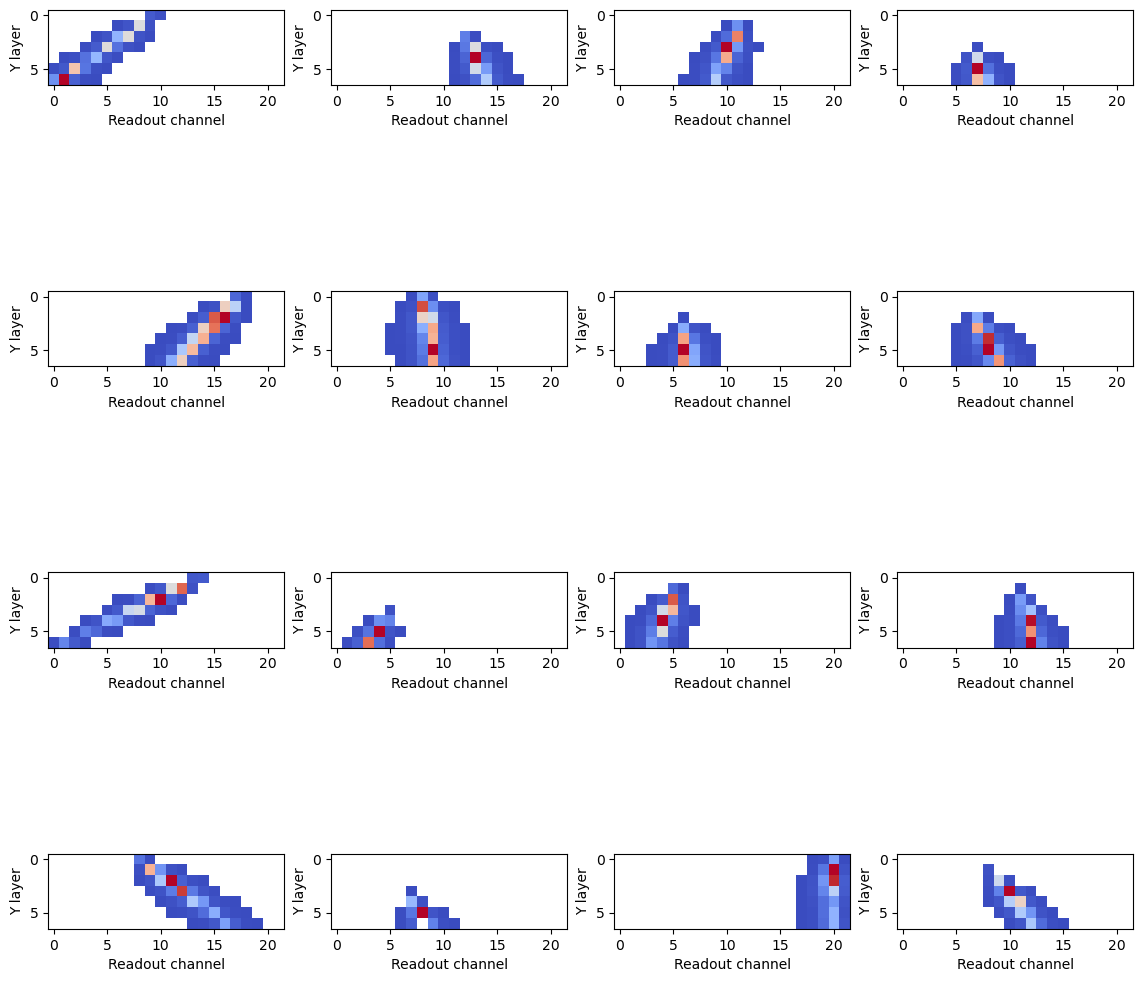

In [8]:
n_c = 4
n_r = 4
fig, ax = plt.subplots(n_c, n_r, figsize=(14, 14))
for i, ax in enumerate(fig.axes):
    # Here we make a copy so we can manipulate the array without changing it in calorimeter_images
    image = calorimeter_images[i].copy()
    # Filling the zero values with NaNs will show us white space where there is zero deposits recorded.
    # Note that if we didn't have the copy there, this would insert NaNs into calorimeter_images.
    image[image == 0] = 'nan'
    ax.imshow(image[1:15:2,:,0], cmap="coolwarm")
    ax.set_xlabel("Readout channel")
    ax.set_ylabel("Y layer")
plt.show()

From these images we can see how there are different showers for photons/electrons and protons. Protons tend to have broader showers since they ionize several layers and thus deposit their energy across multiple layers. Whereas electrons/photons tend to have narrower showers and thus have a collimated energy deposit.

### Let's look at the distribution of the pixel intensities for each layer

We will start by looking at the distribution max pixel across all 22 channels as a function of the layers.

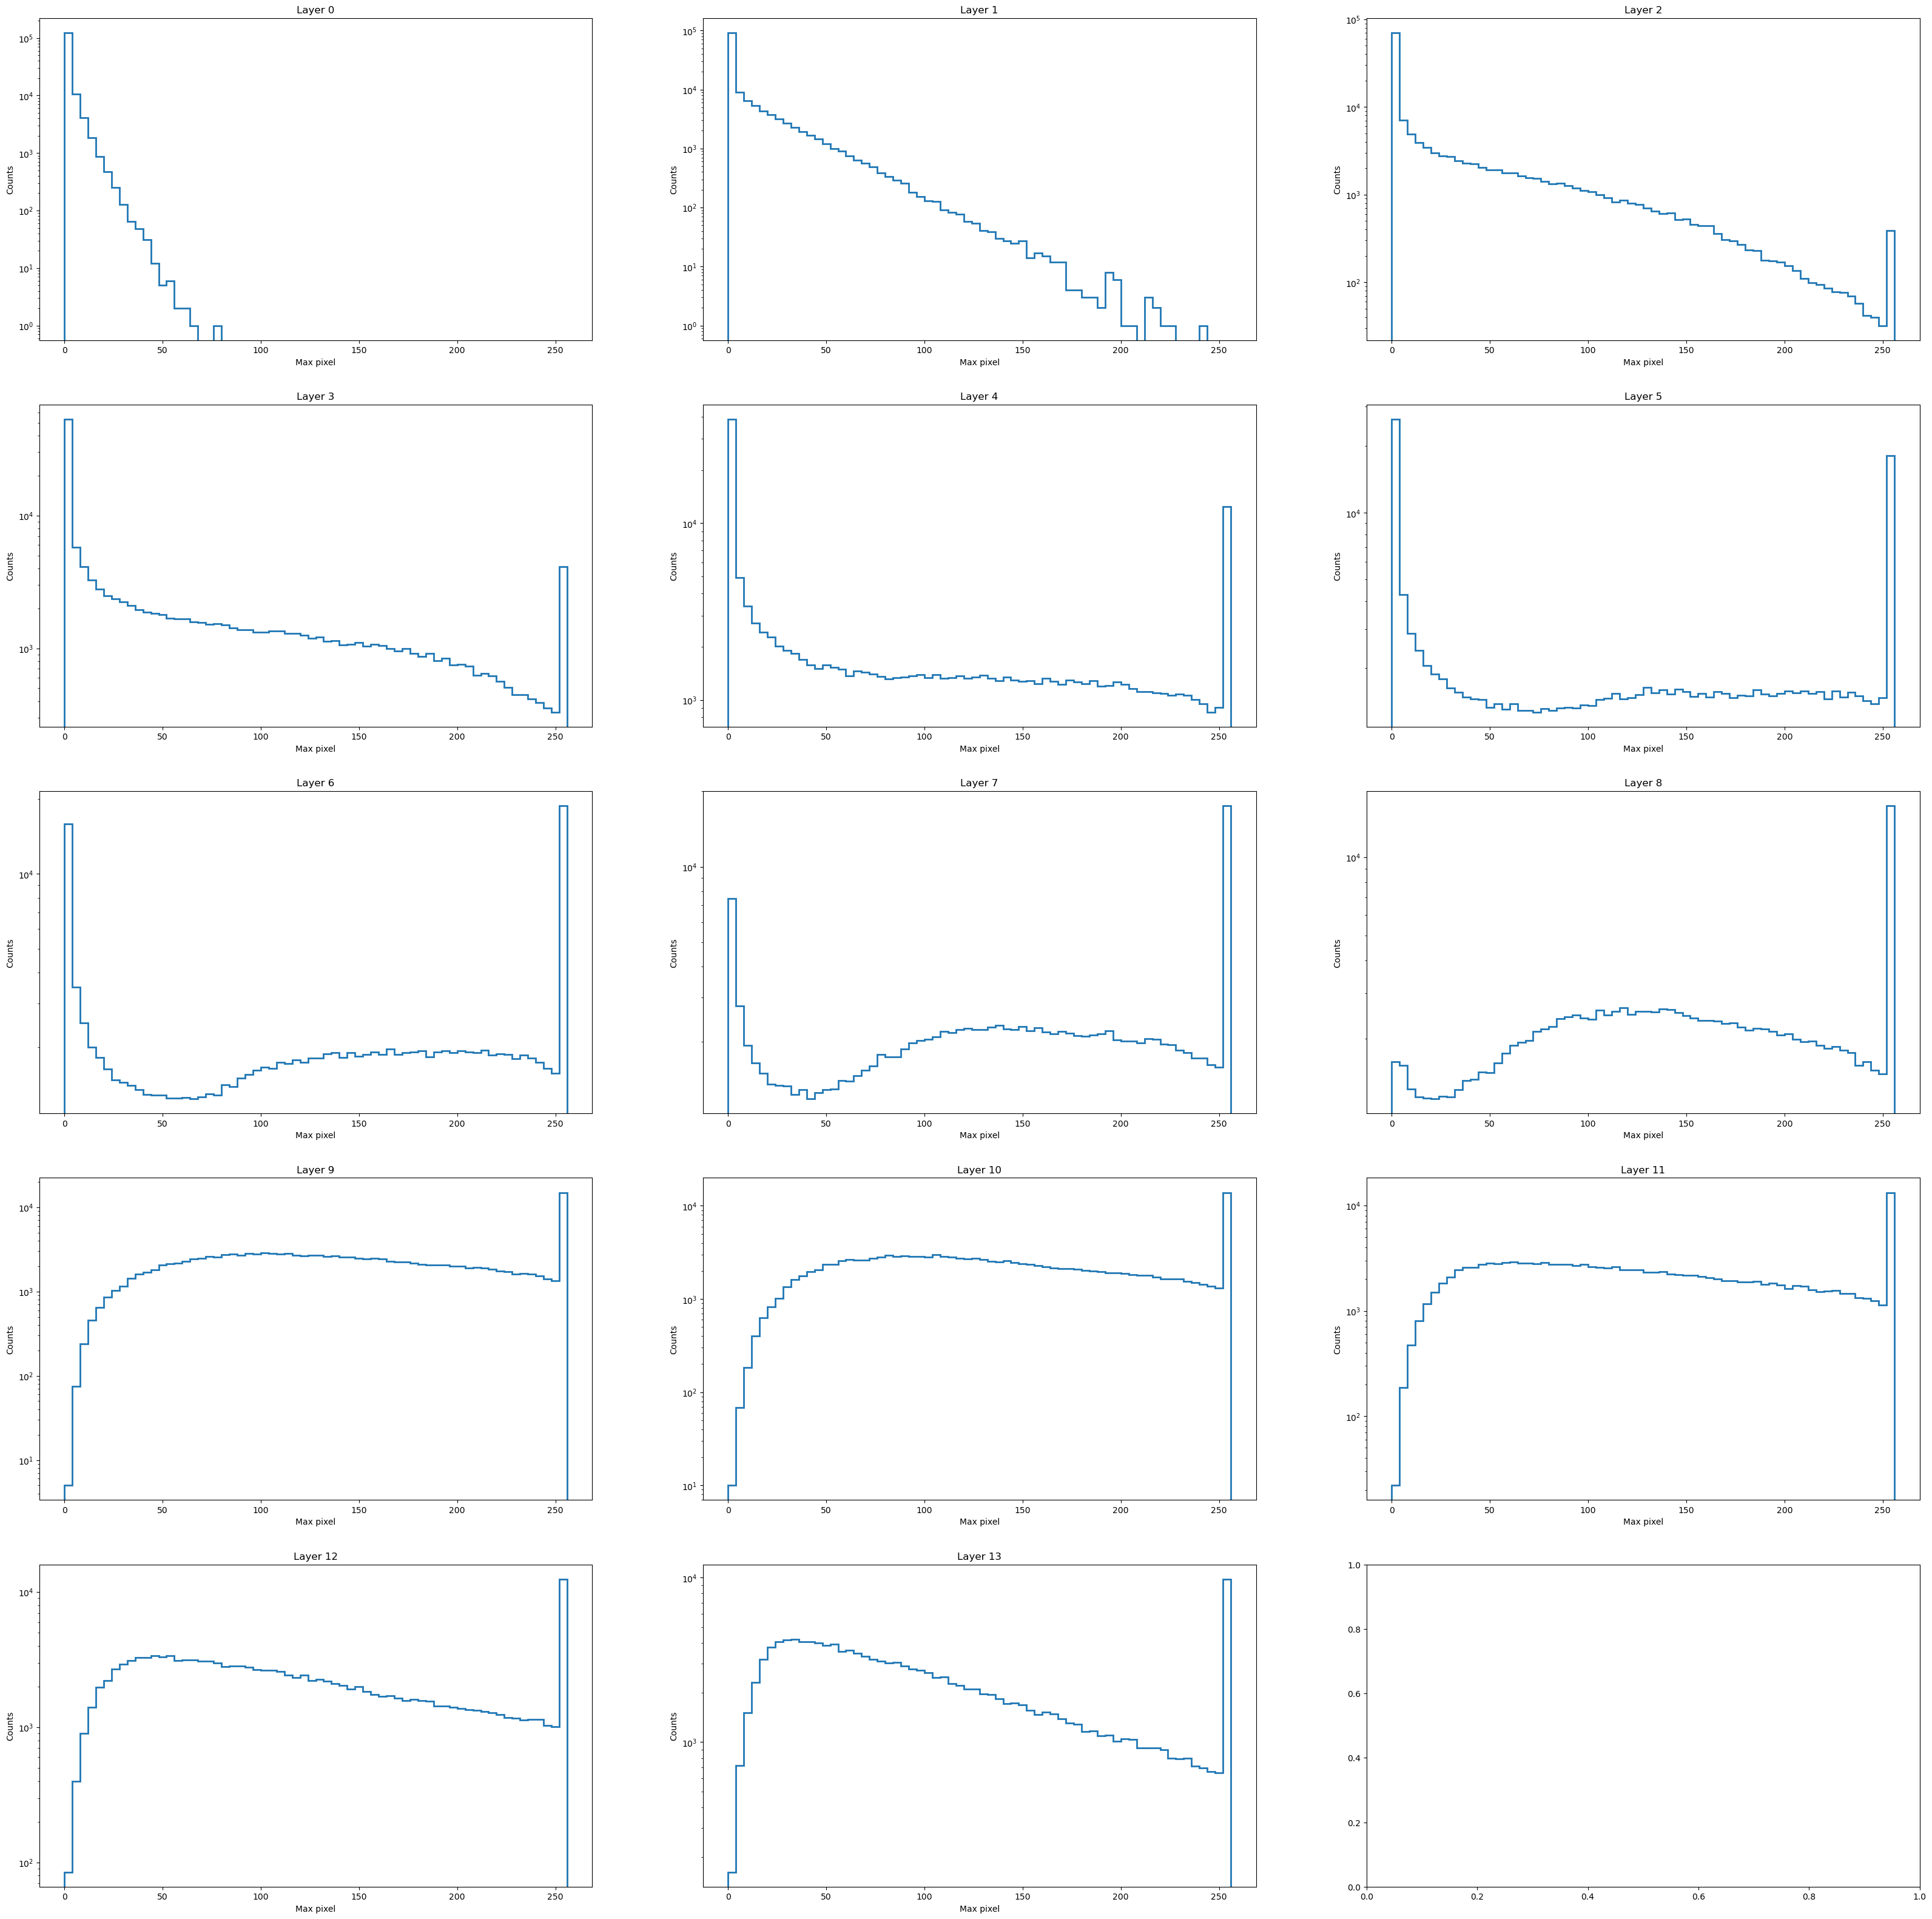

In [9]:
max_pixels = calorimeter_images.max(axis=3)
max_pixels_layer = max_pixels.max(axis=2)

fig, _ = plt.subplots(5,3, figsize=(40,40))

axes = fig.axes

for i_layer in range(N_LAYERS):
    axes[i_layer].hist(max_pixels_layer[:,i_layer], bins=np.linspace(0,256,65), histtype='step', linewidth=2)
    axes[i_layer].set_title(f"Layer {i_layer}")
    axes[i_layer].set_xlabel("Max pixel")
    axes[i_layer].set_ylabel("Counts")
    axes[i_layer].semilogy()

plt.show()
fig.clf()

Looking at the distributions of the max pixel per layer it is interesting to observe that the evolution of the shower shape across the various layers.

Since the first couple of layers have a sharply falling distribution, we can see that the particle goes through the detector without losing much energy. Then as we go deeper in the layers we can see the energy dissipated increases, thus the distribution broadens.

### Let's look at the distribution of the pixel intensities for each channel

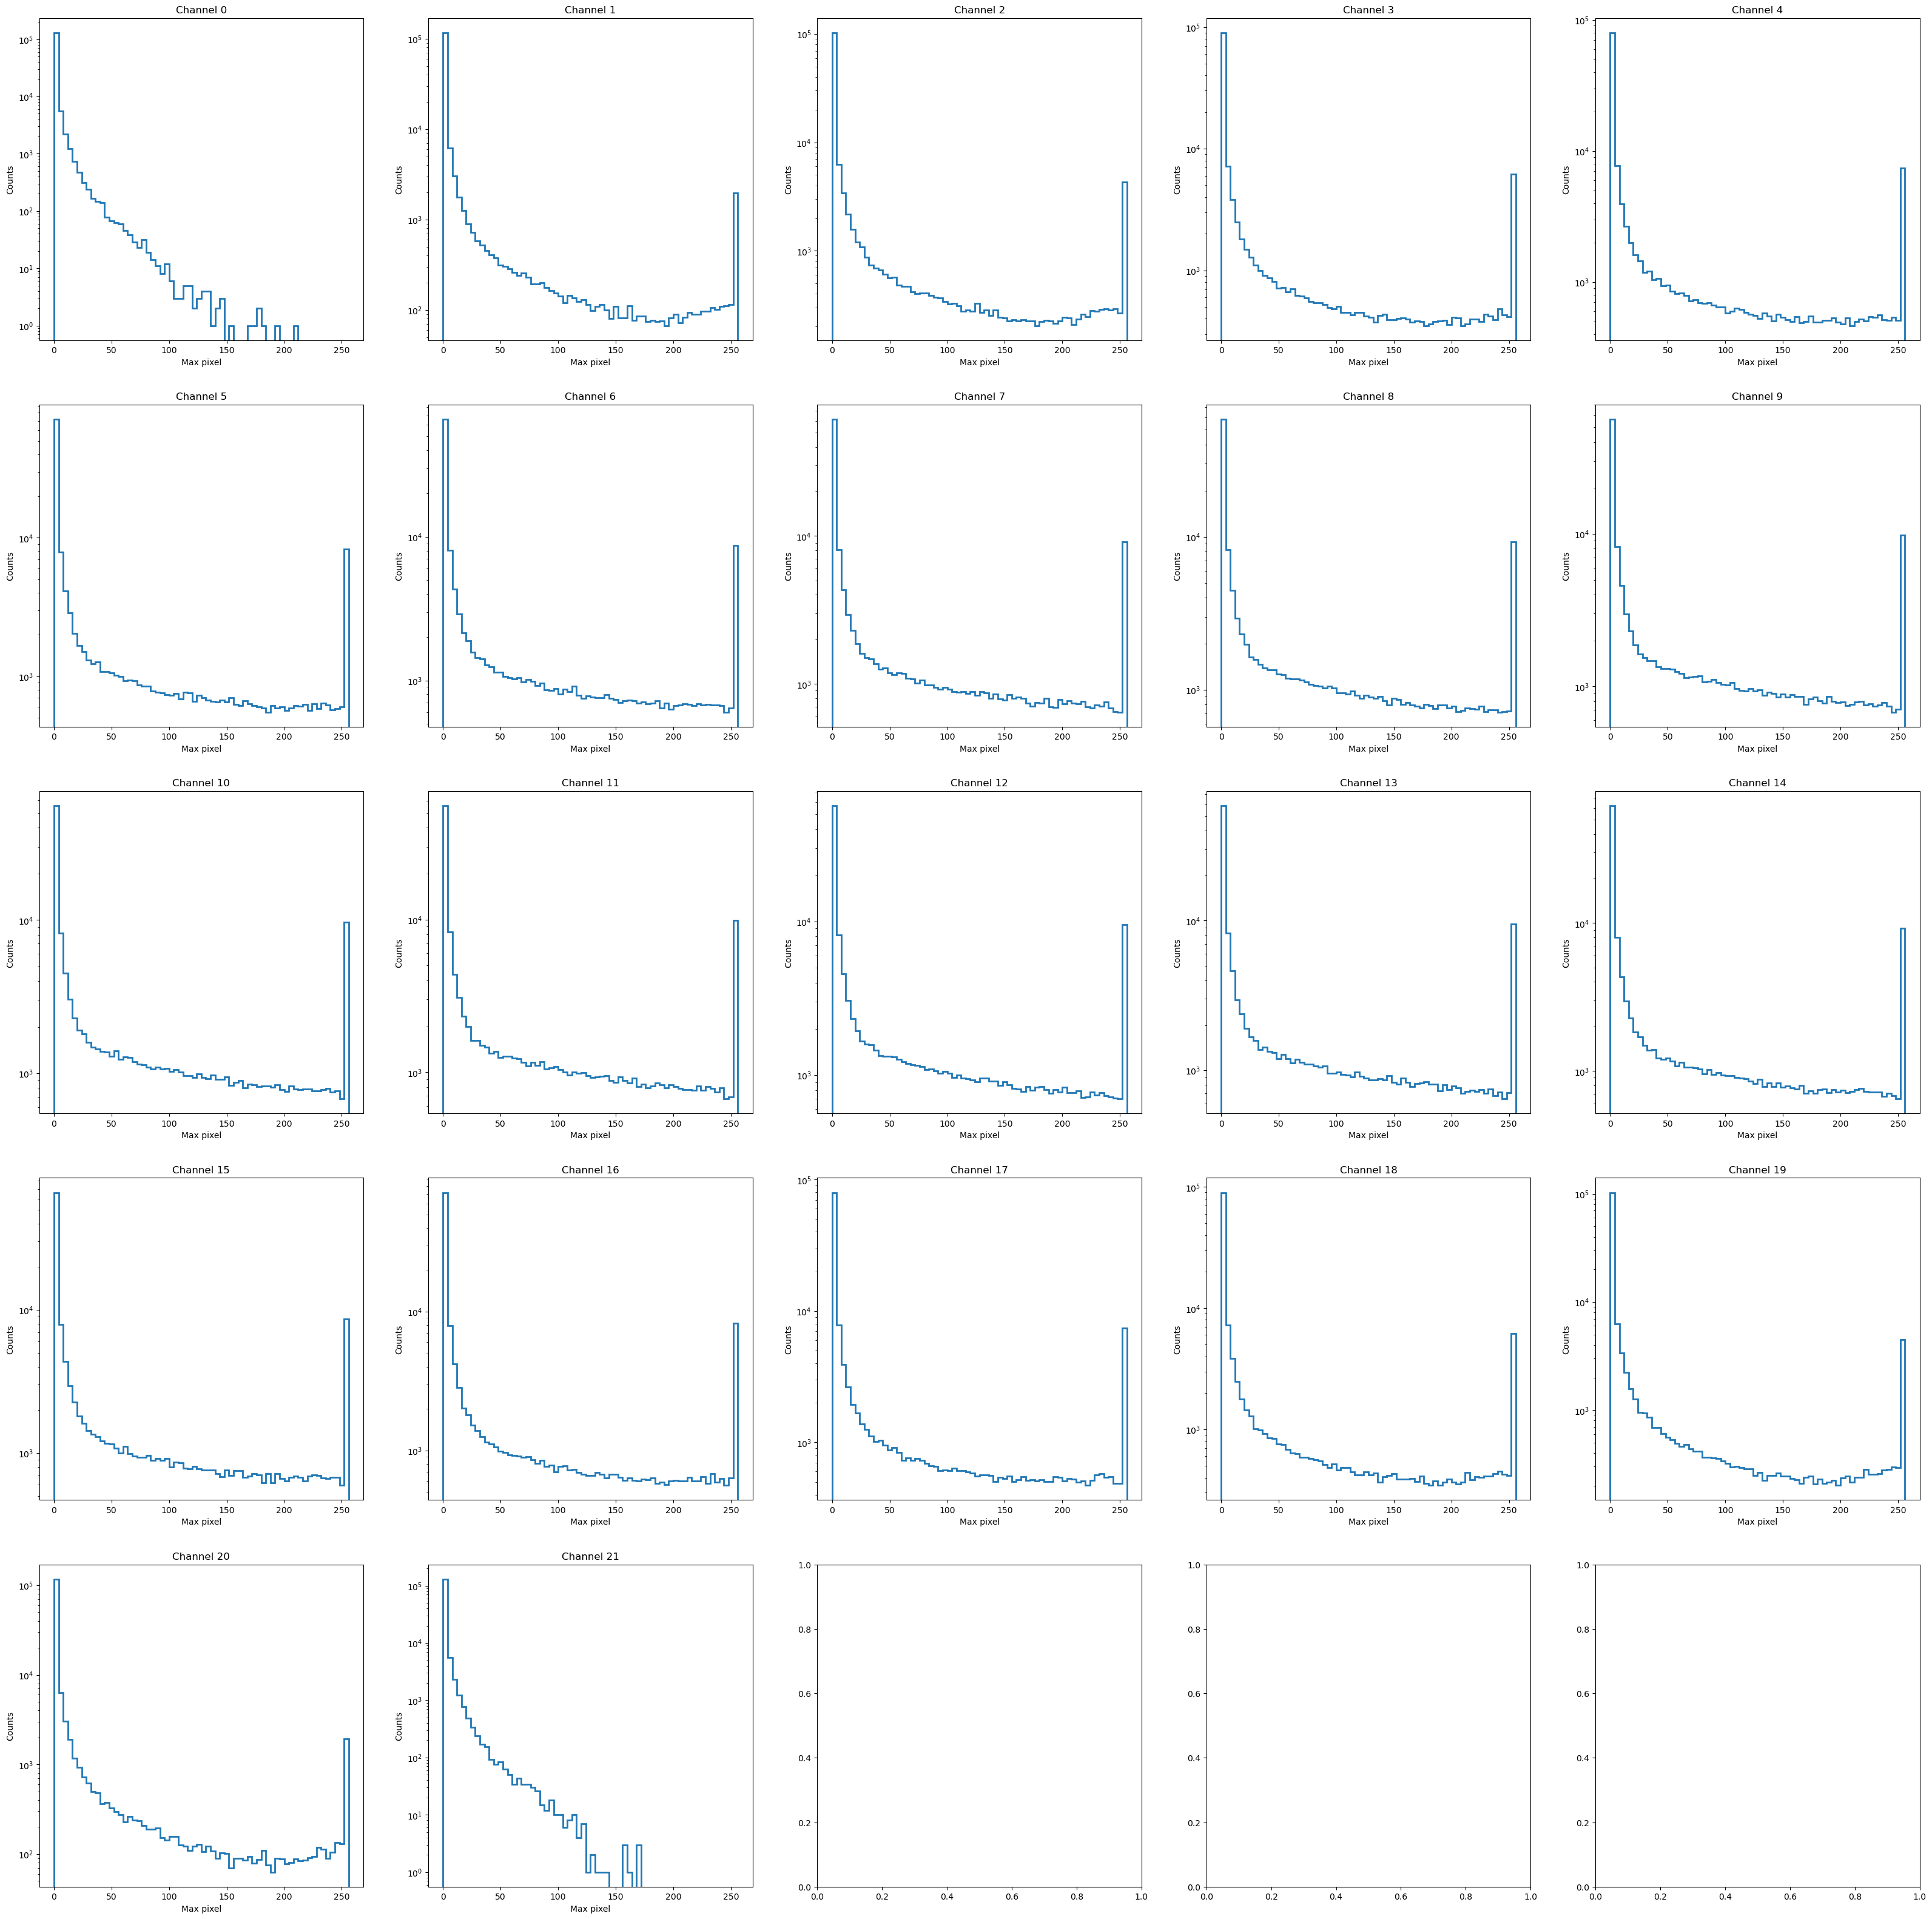

In [10]:
max_pixels_channel = max_pixels.max(axis=1)

fig, _ = plt.subplots(5,5, figsize=(40,40))

axes = fig.axes

for i_channel in range(N_CHANNELS):
    axes[i_channel].hist(max_pixels_channel[:,i_channel], bins=np.linspace(0,256,65), histtype='step', linewidth=2)
    axes[i_channel].set_title(f"Channel {i_channel}")
    axes[i_channel].set_xlabel("Max pixel")
    axes[i_channel].set_ylabel("Counts")
    axes[i_channel].semilogy()

plt.show()
fig.clf()

When we plot the max pixel distribution as a function of the channels we can see that not one particular channel is favored. Thus, the particles have no preference to dissipate their energies in a particular channel.

### Let's look at the sum of the pixel hit values per layer

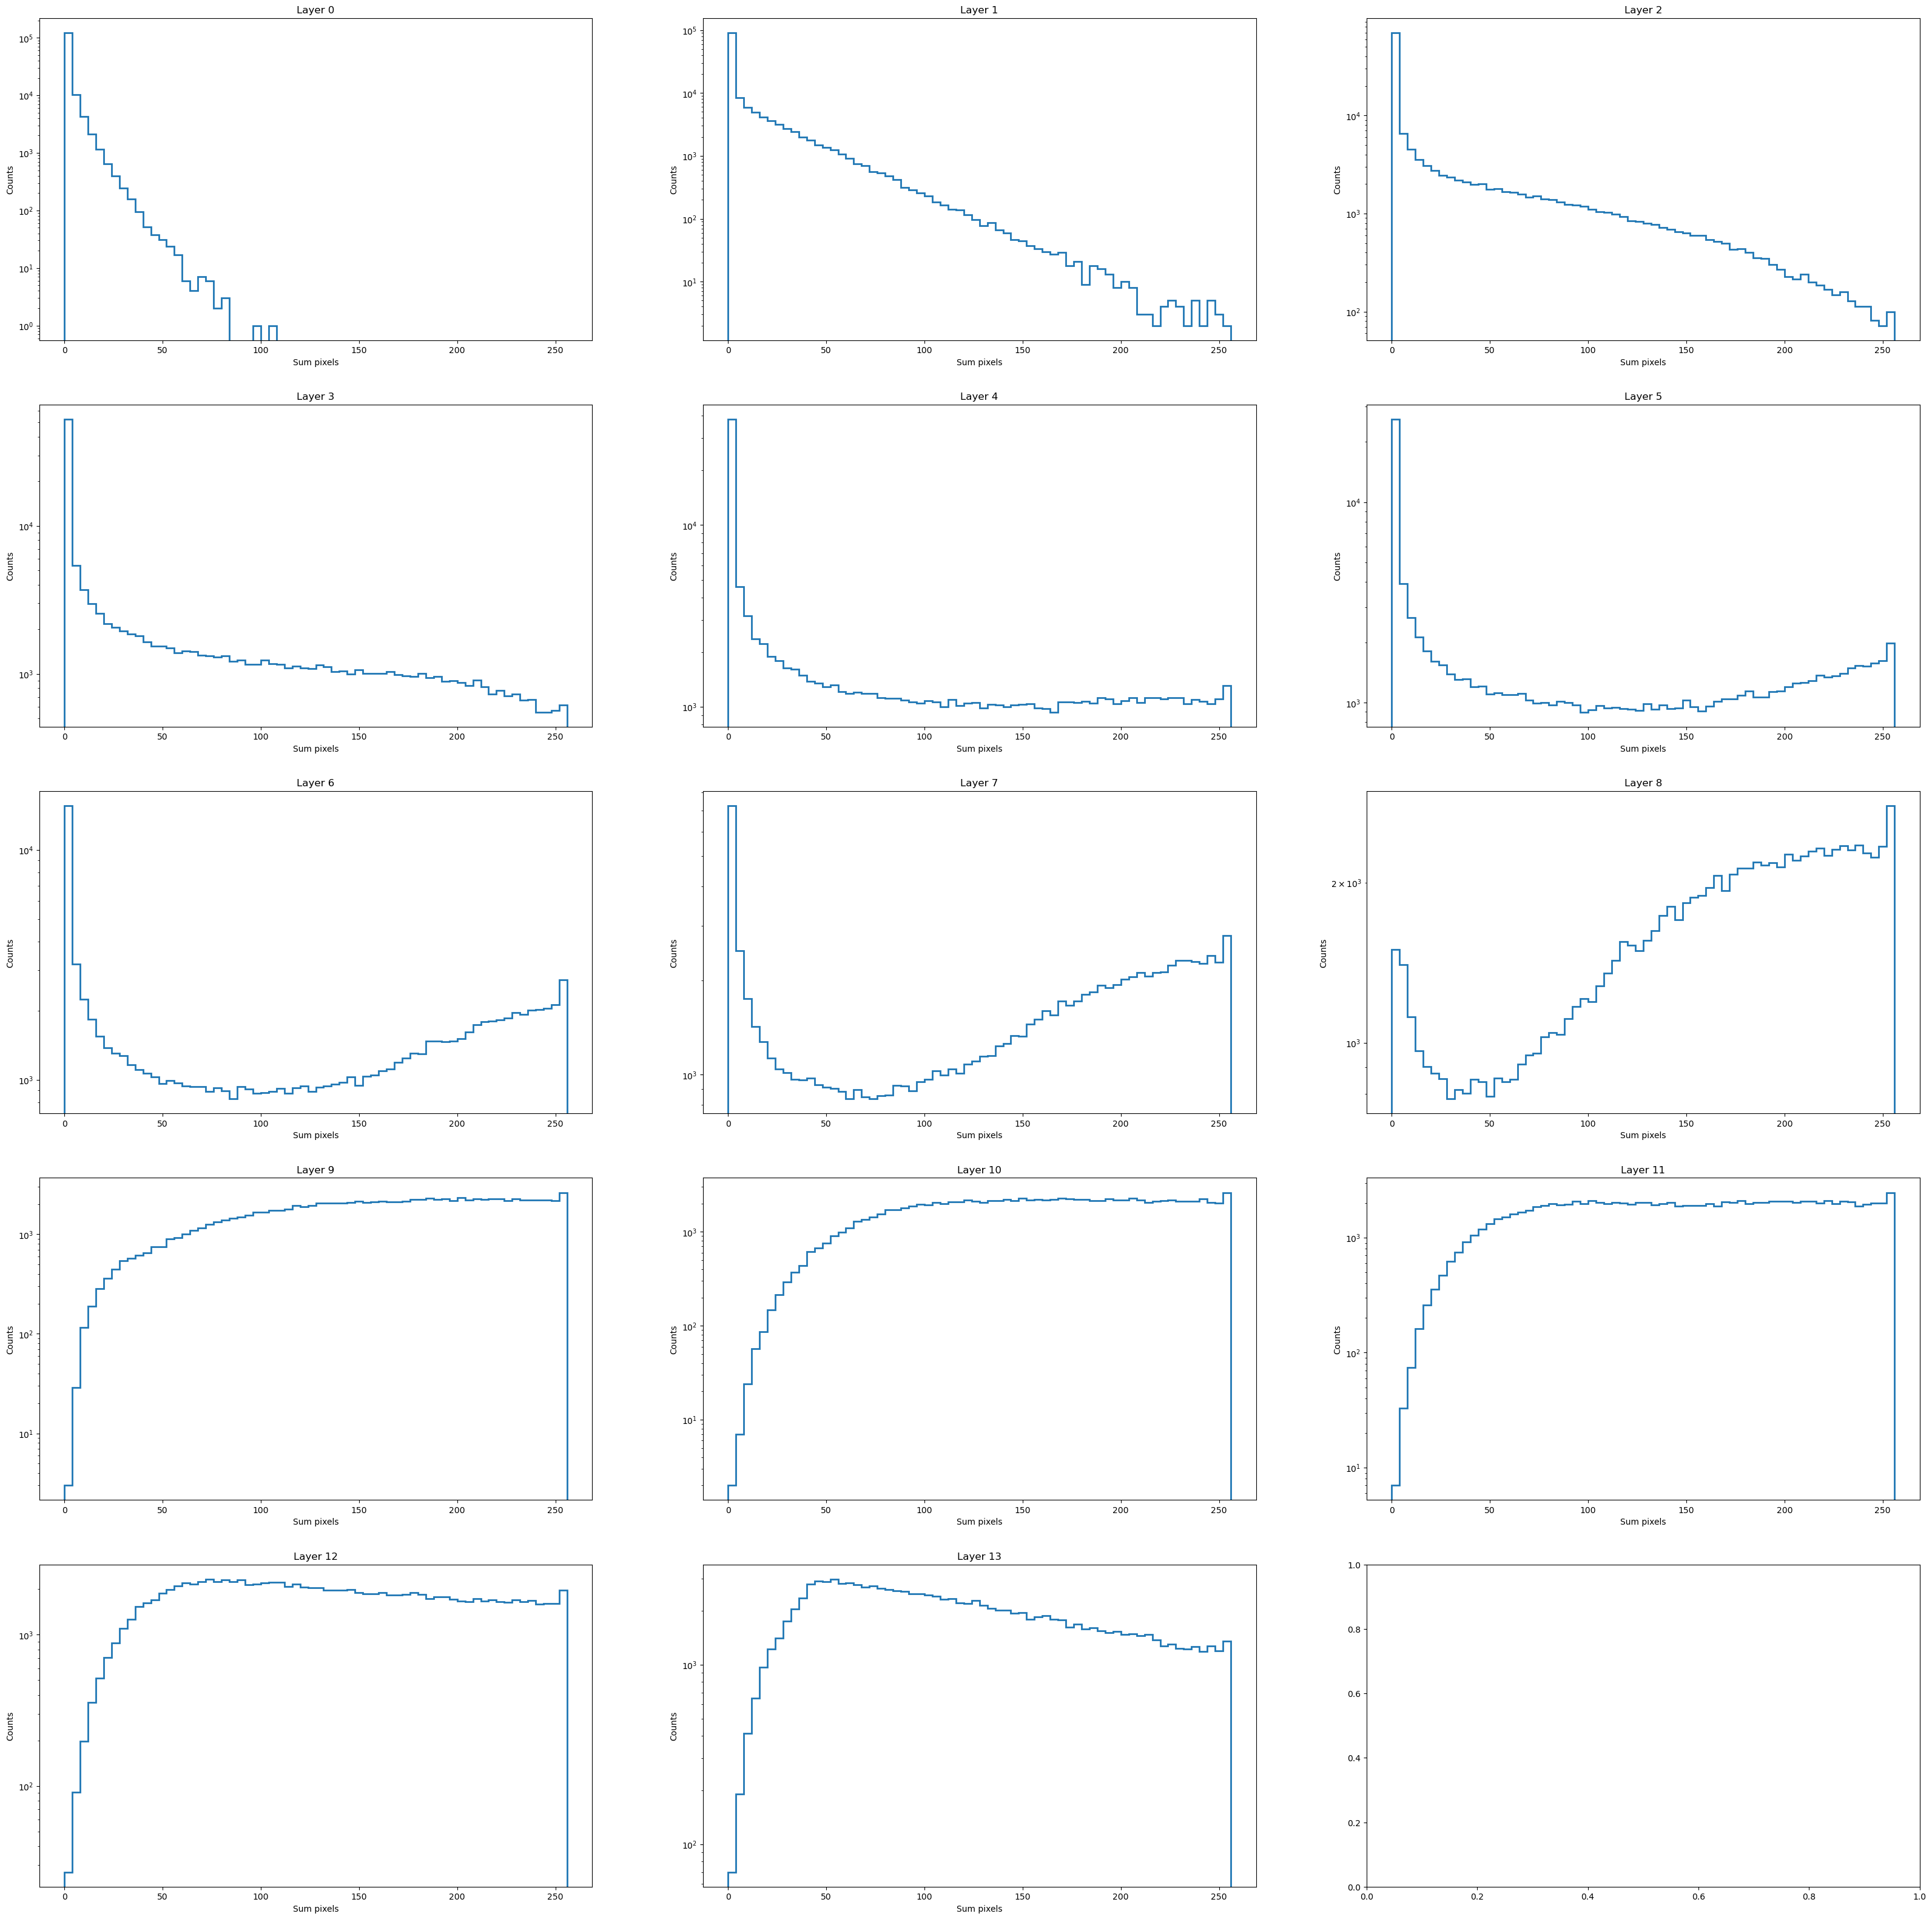

In [11]:
pixel_density = calorimeter_images[:,:,:,0]

sum_pixels_layer = pixel_density.sum(axis=2)

fig, _ = plt.subplots(5,3, figsize=(40,40))
axes = fig.axes

for i_layer in range(N_LAYERS):
    axes[i_layer].hist(sum_pixels_layer[:,i_layer], bins=np.linspace(0,256,65), histtype='step', linewidth=2)
    axes[i_layer].set_title(f"Layer {i_layer}")
    axes[i_layer].set_xlabel("Sum pixels")
    axes[i_layer].set_ylabel("Counts")
    axes[i_layer].semilogy()

plt.show()
fig.clf()

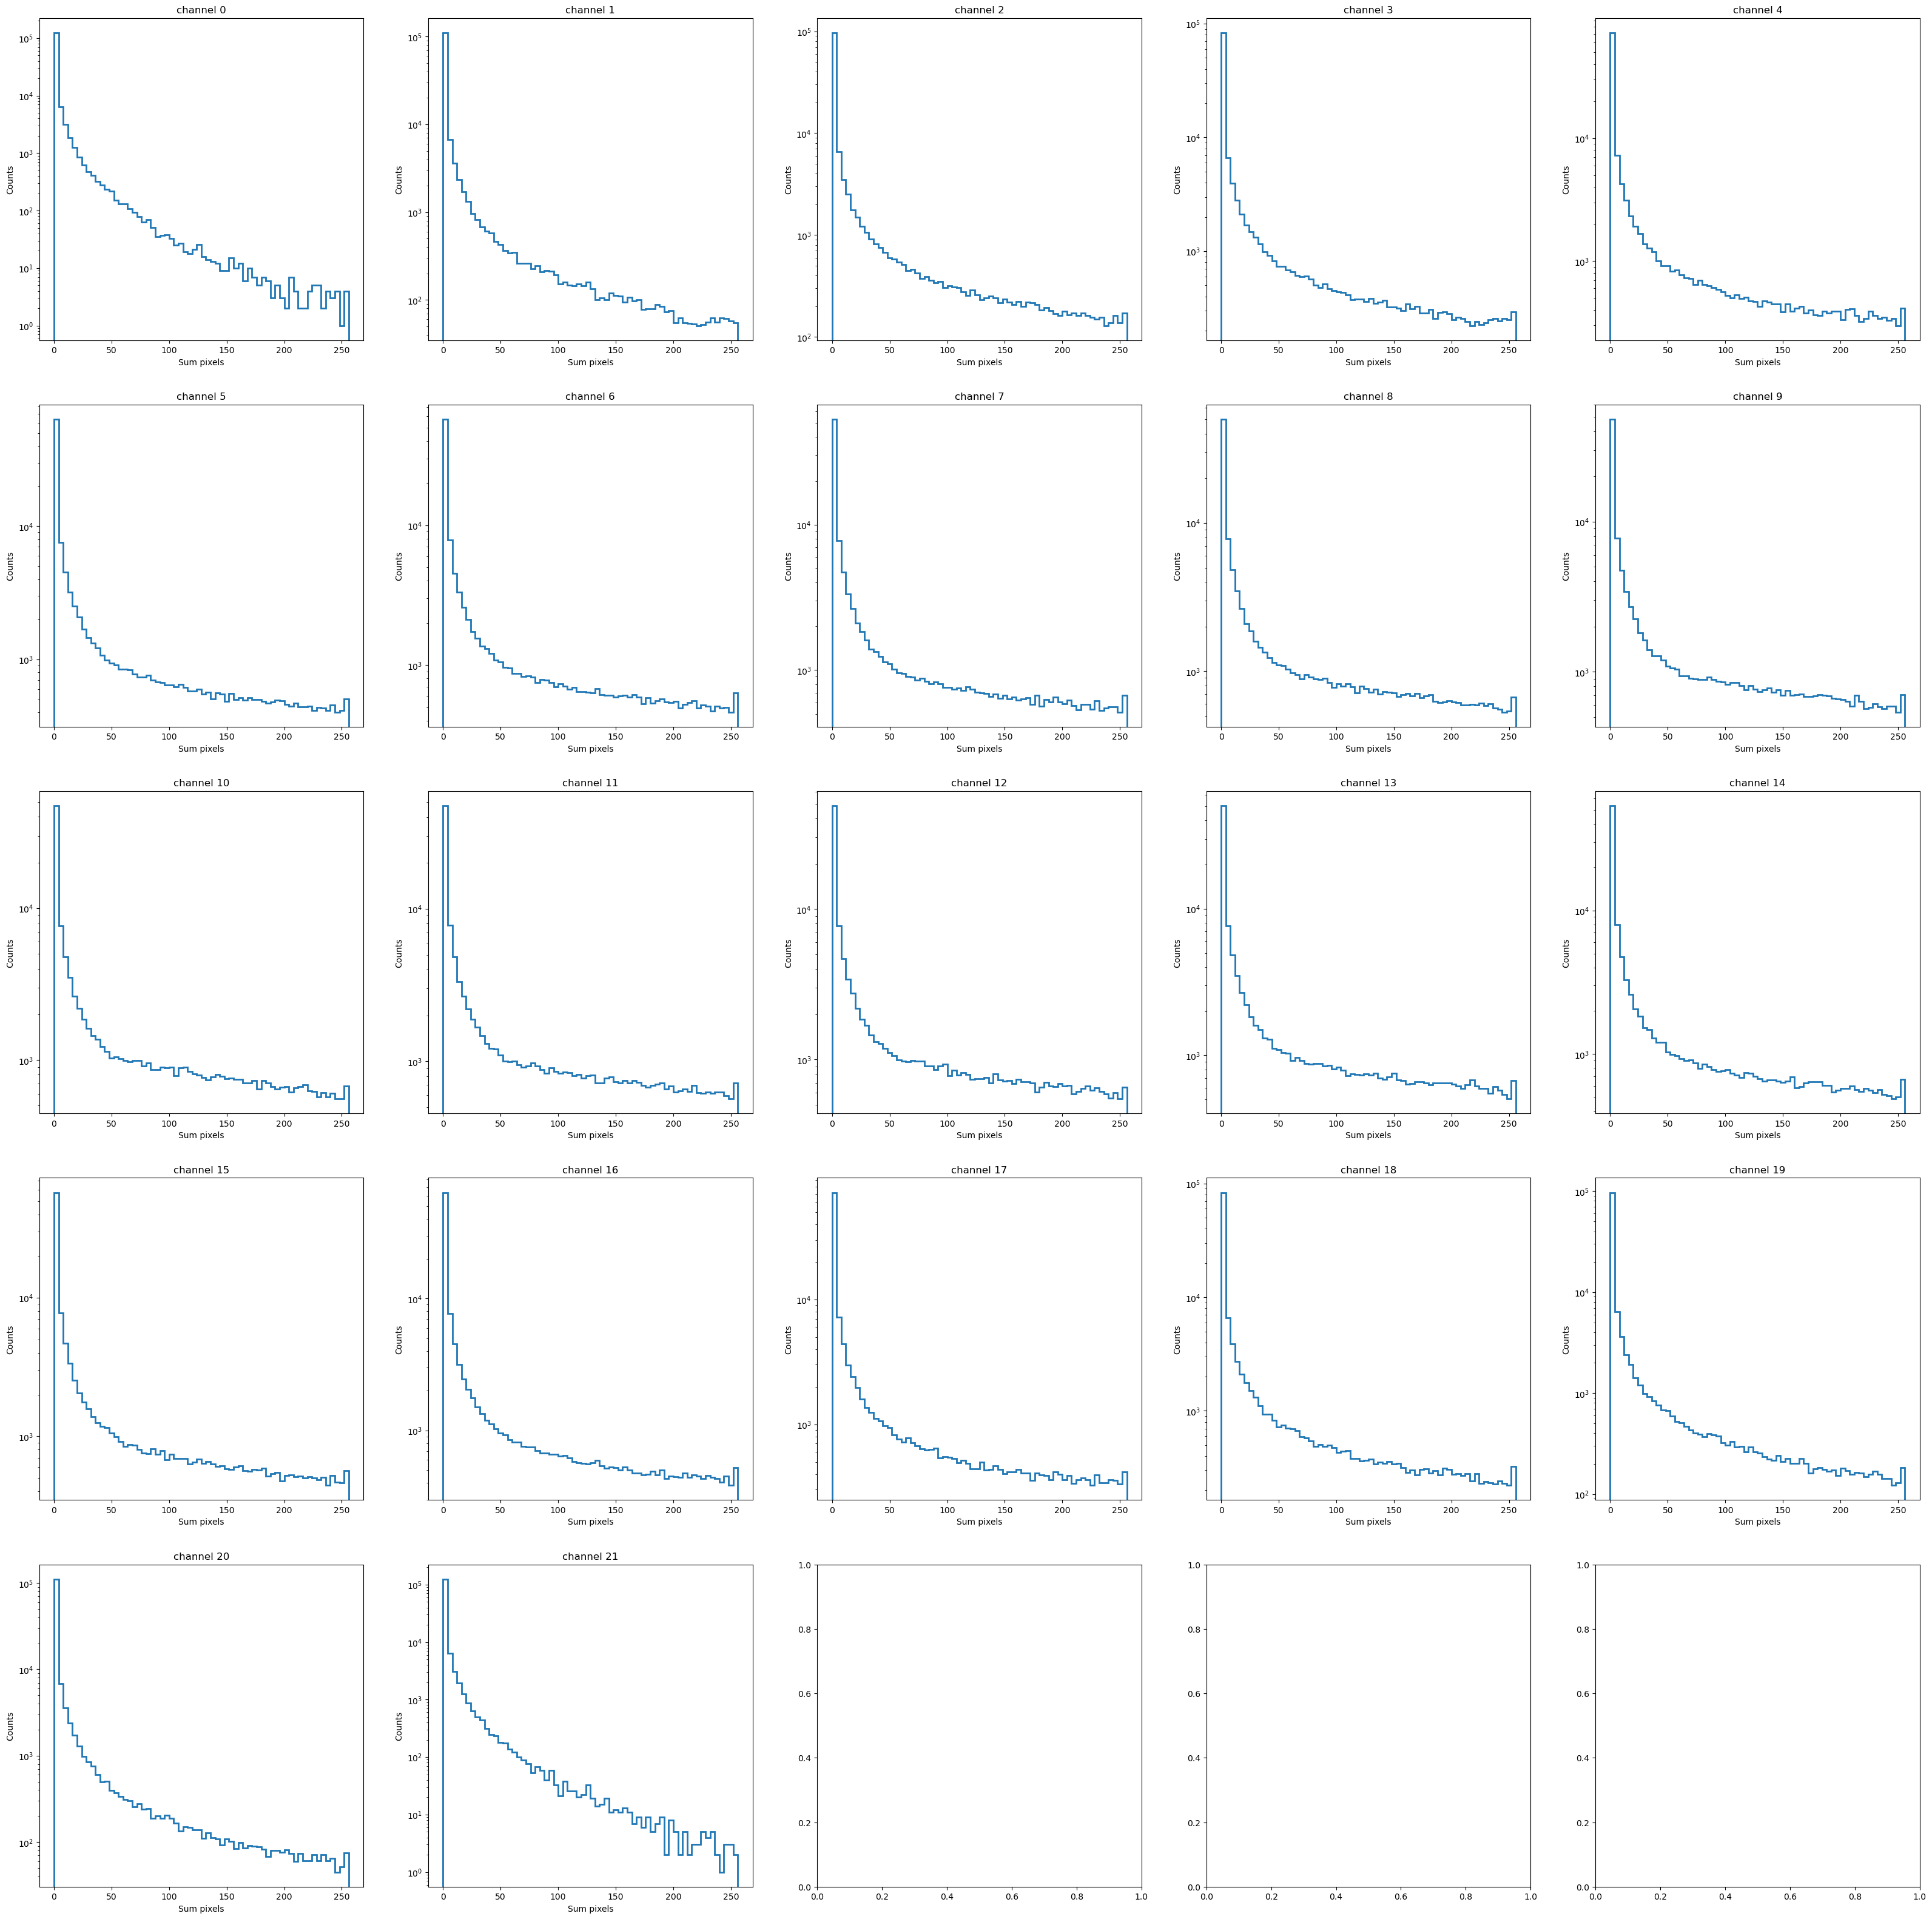

In [12]:
# pixel_density = calorimeter_images[:,:,:,0]

sum_pixels_channel = pixel_density.sum(axis=1)

fig, _ = plt.subplots(5,5, figsize=(40,40))
axes = fig.axes

for i_channel in range(N_CHANNELS):
    axes[i_channel].hist(sum_pixels_channel[:,i_channel], bins=np.linspace(0,256,65), histtype='step', linewidth=2)
    axes[i_channel].set_title(f"channel {i_channel}")
    axes[i_channel].set_xlabel("Sum pixels")
    axes[i_channel].set_ylabel("Counts")
    axes[i_channel].semilogy()

plt.show()
fig.clf()

## Define a `Center of Gravity (CoG)` for the images

$$
    CoG = \frac{\sum_{i} i\cdot \textrm{pixelValue}_{i}}{\sum_{i} \textrm{pixelValue}_{i}}
$$

Here, the index `i` runs over all the channels in one layer.

In [13]:
def CoG_np(image):
    
    index_array = np.full(shape=image.shape, fill_value=np.arange(image.shape[1]), dtype="float")
    weighted_product = index_array * image
    
    numerator = weighted_product.sum(axis=1)
    denominator = image.sum(axis=1)
    
    cog = numerator / denominator 
    cog = np.nan_to_num(cog, nan=0.0, posinf=0.0, neginf=0.0)
    
    return cog

In [14]:
cog_images = np.array([CoG_np(image) for image in calorimeter_images[...,0]])

/var/folders/gd/ddv3zxnd0fx9cx3cw9zc9jbw0000gn/T/ipykernel_27215/2250345027.py:9: RuntimeWarning: invalid value encountered in divide
  cog = numerator / denominator


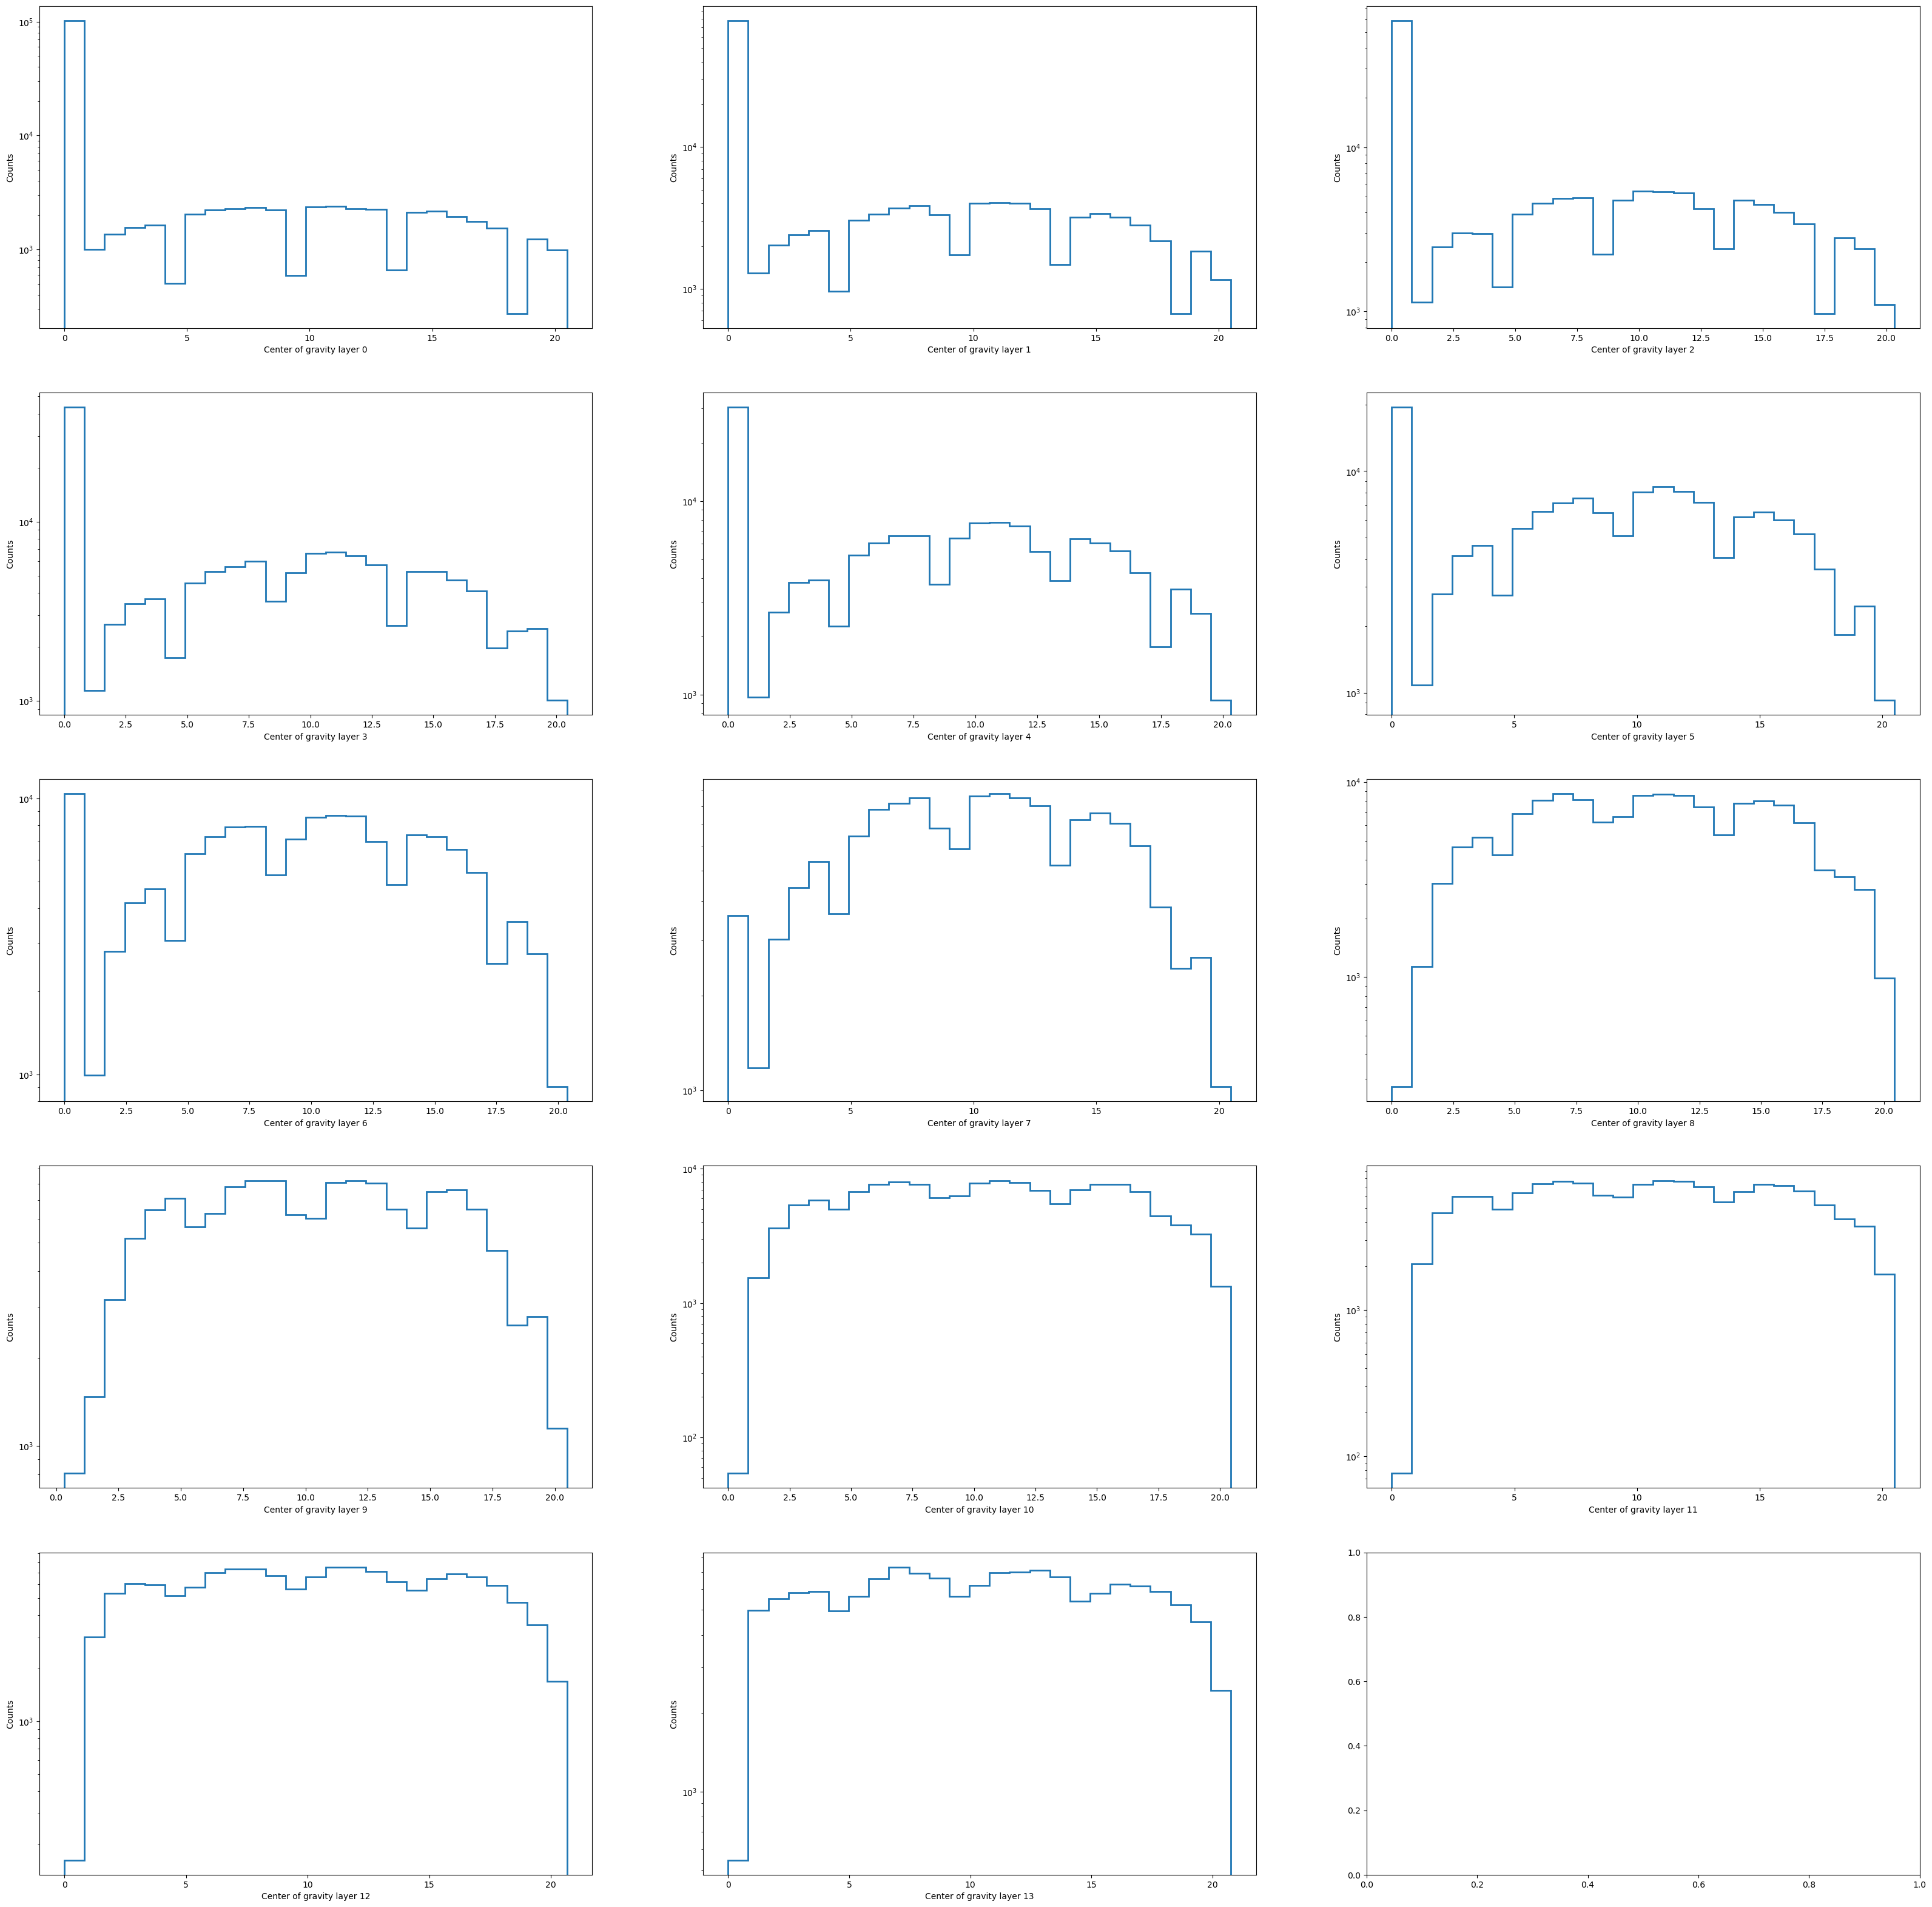

In [15]:
fig, _ = plt.subplots(5,3, figsize=(40,40))

axes = fig.axes

for i_layer in range(N_LAYERS):
    axes[i_layer].hist(cog_images[:,i_layer], bins=25, histtype="step", linewidth=2)
    axes[i_layer].set_xlabel(f"Center of gravity layer {i_layer}")
    axes[i_layer].set_ylabel("Counts")
    axes[i_layer].semilogy()

plt.show()

### Let's look at the pixel density across constant layers and constant channels

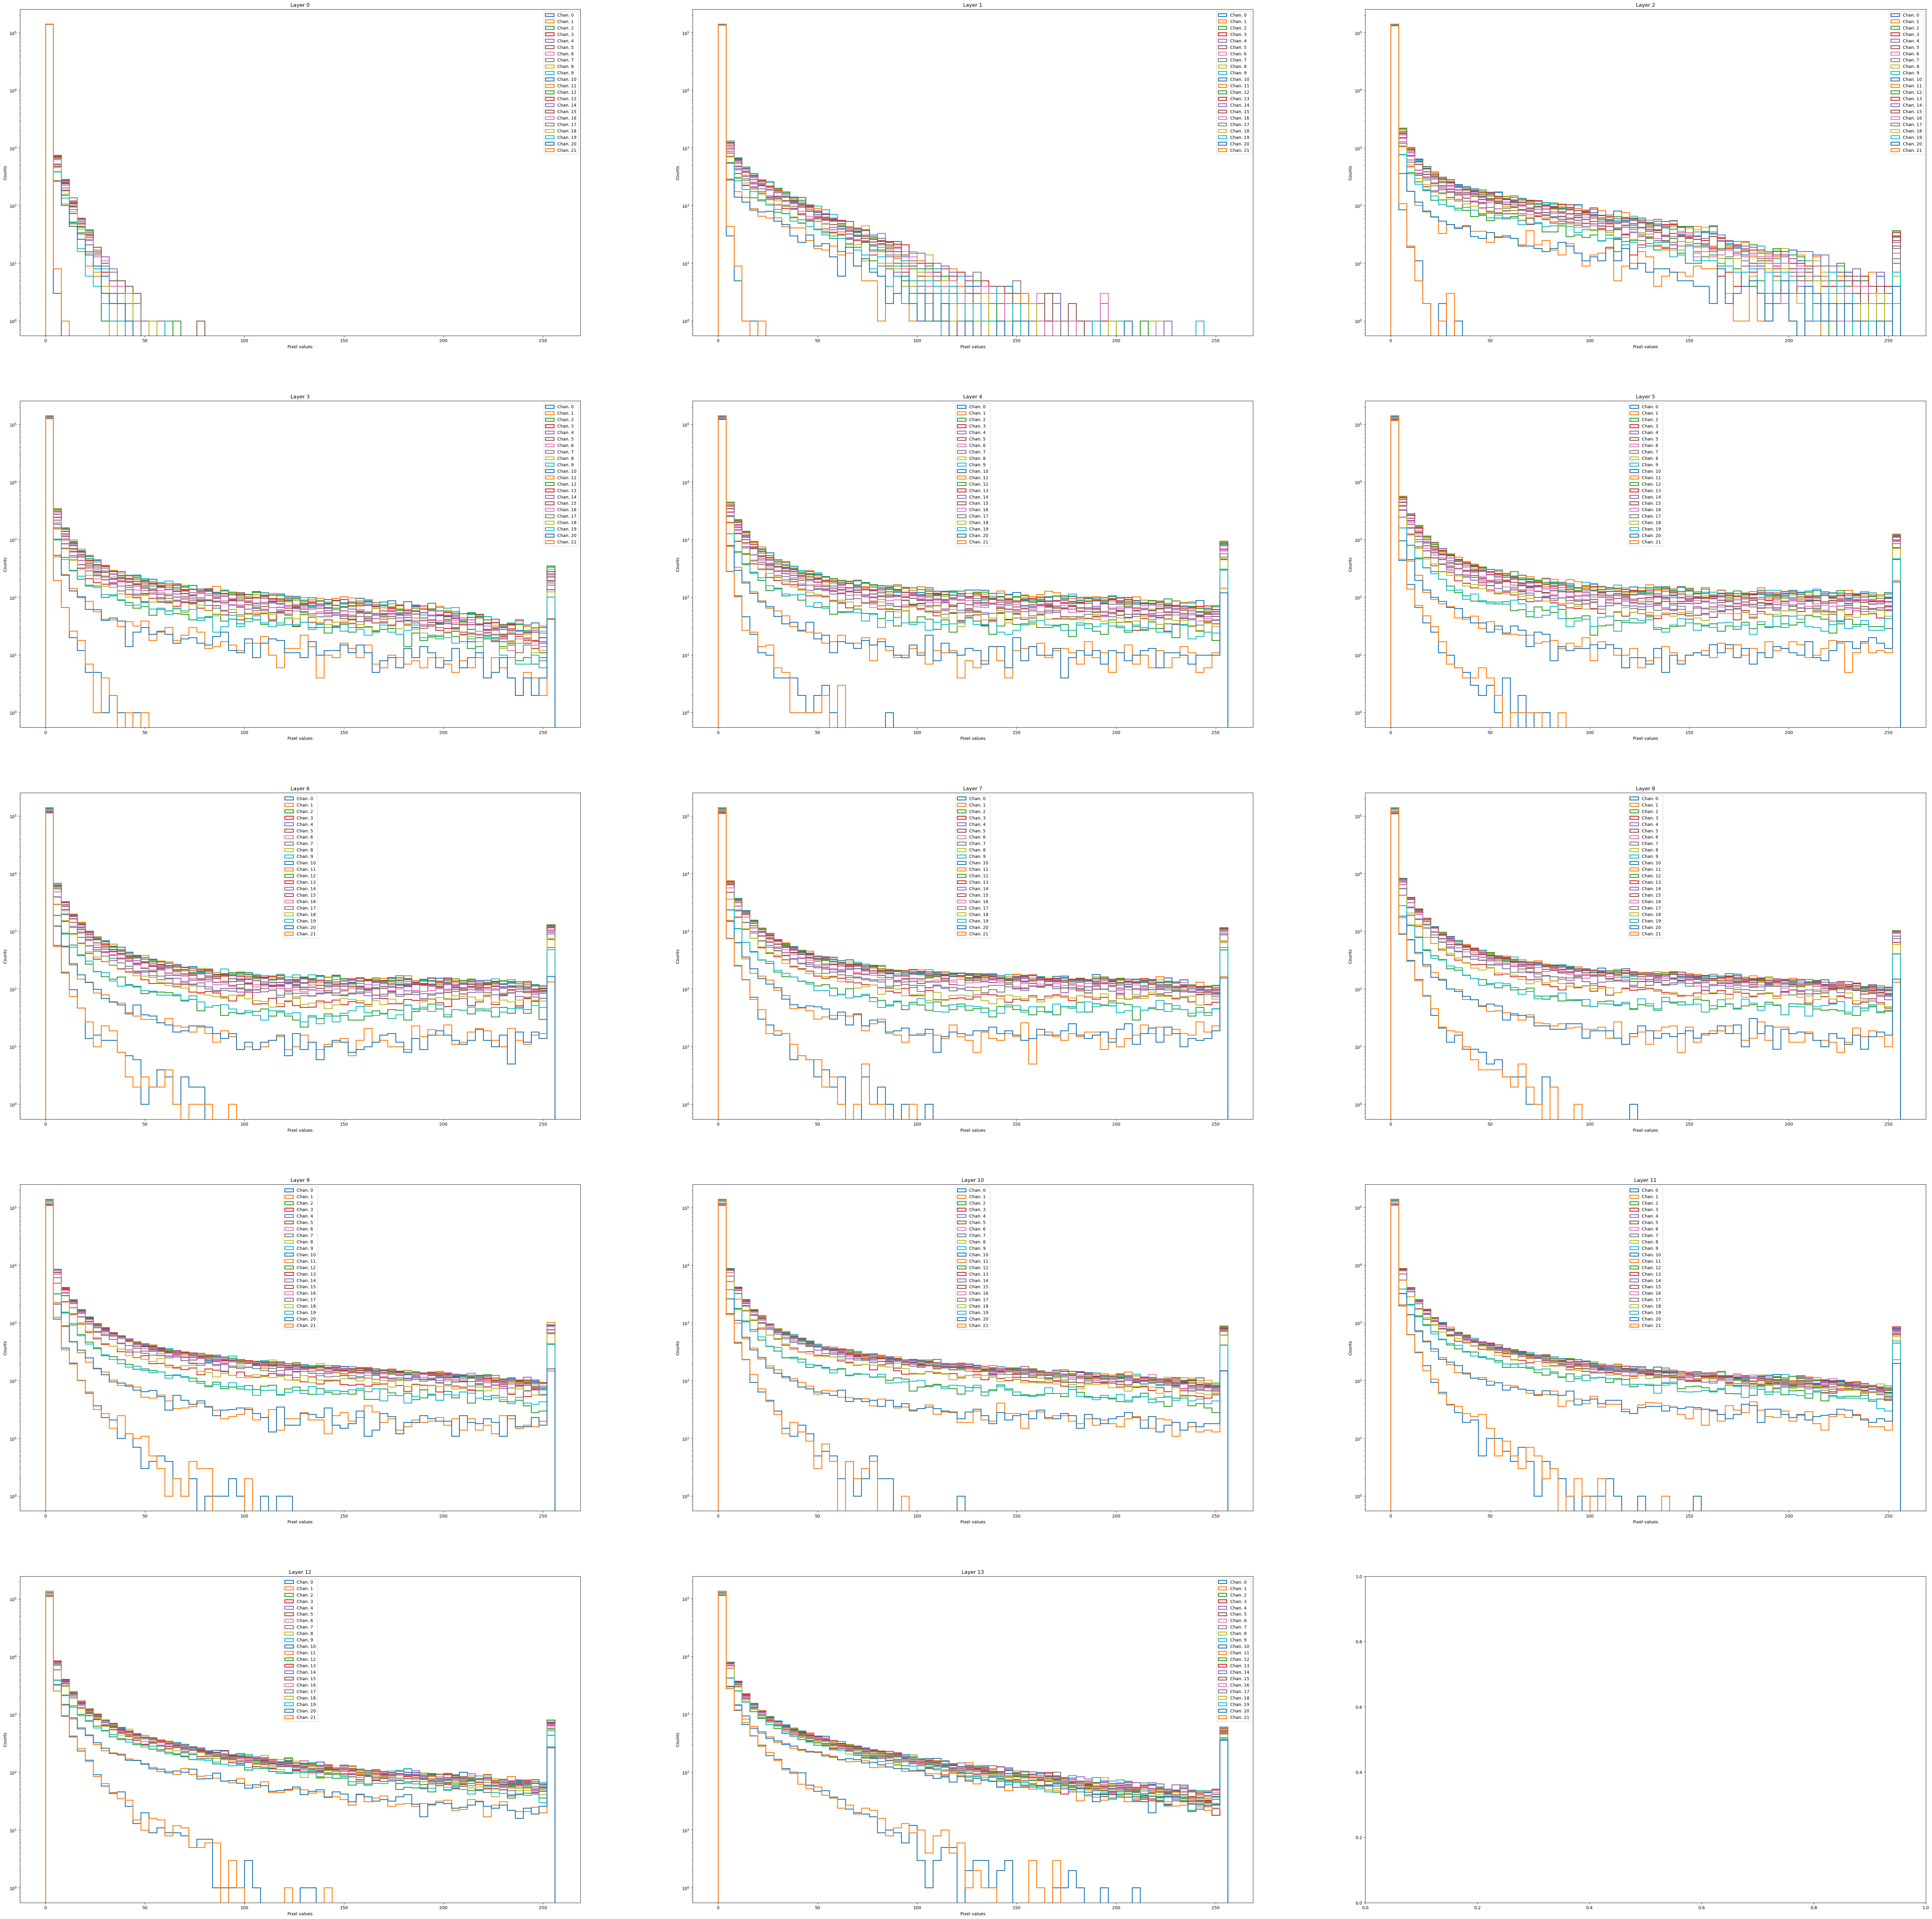

In [16]:
pixel_density = calorimeter_images[:,:,:,0]

fig, _ = plt.subplots(5,3, figsize=(80,80))
axes = fig.axes

for i_layer in range(N_LAYERS):
    for i_channel in range(N_CHANNELS):
        axes[i_layer].hist(pixel_density[:,i_layer,i_channel], 
                           bins=np.linspace(0,256,65), 
                           histtype="step", 
                           linewidth=2, 
                           label=f"Chan. {i_channel}")
        
    axes[i_layer].set_xlabel("Pixel values")
    axes[i_layer].set_ylabel("Counts")
    axes[i_layer].set_title(f"Layer {i_layer}")
    axes[i_layer].semilogy()
    axes[i_layer].legend()
plt.show()
fig.clf()

In the above set of plots, we are looking at the distribution of pixel values for a layer across all the 22 channels. As we expect the distributions are quite similar except for channels 0 & 1. We will need to investigate further about these channnels.

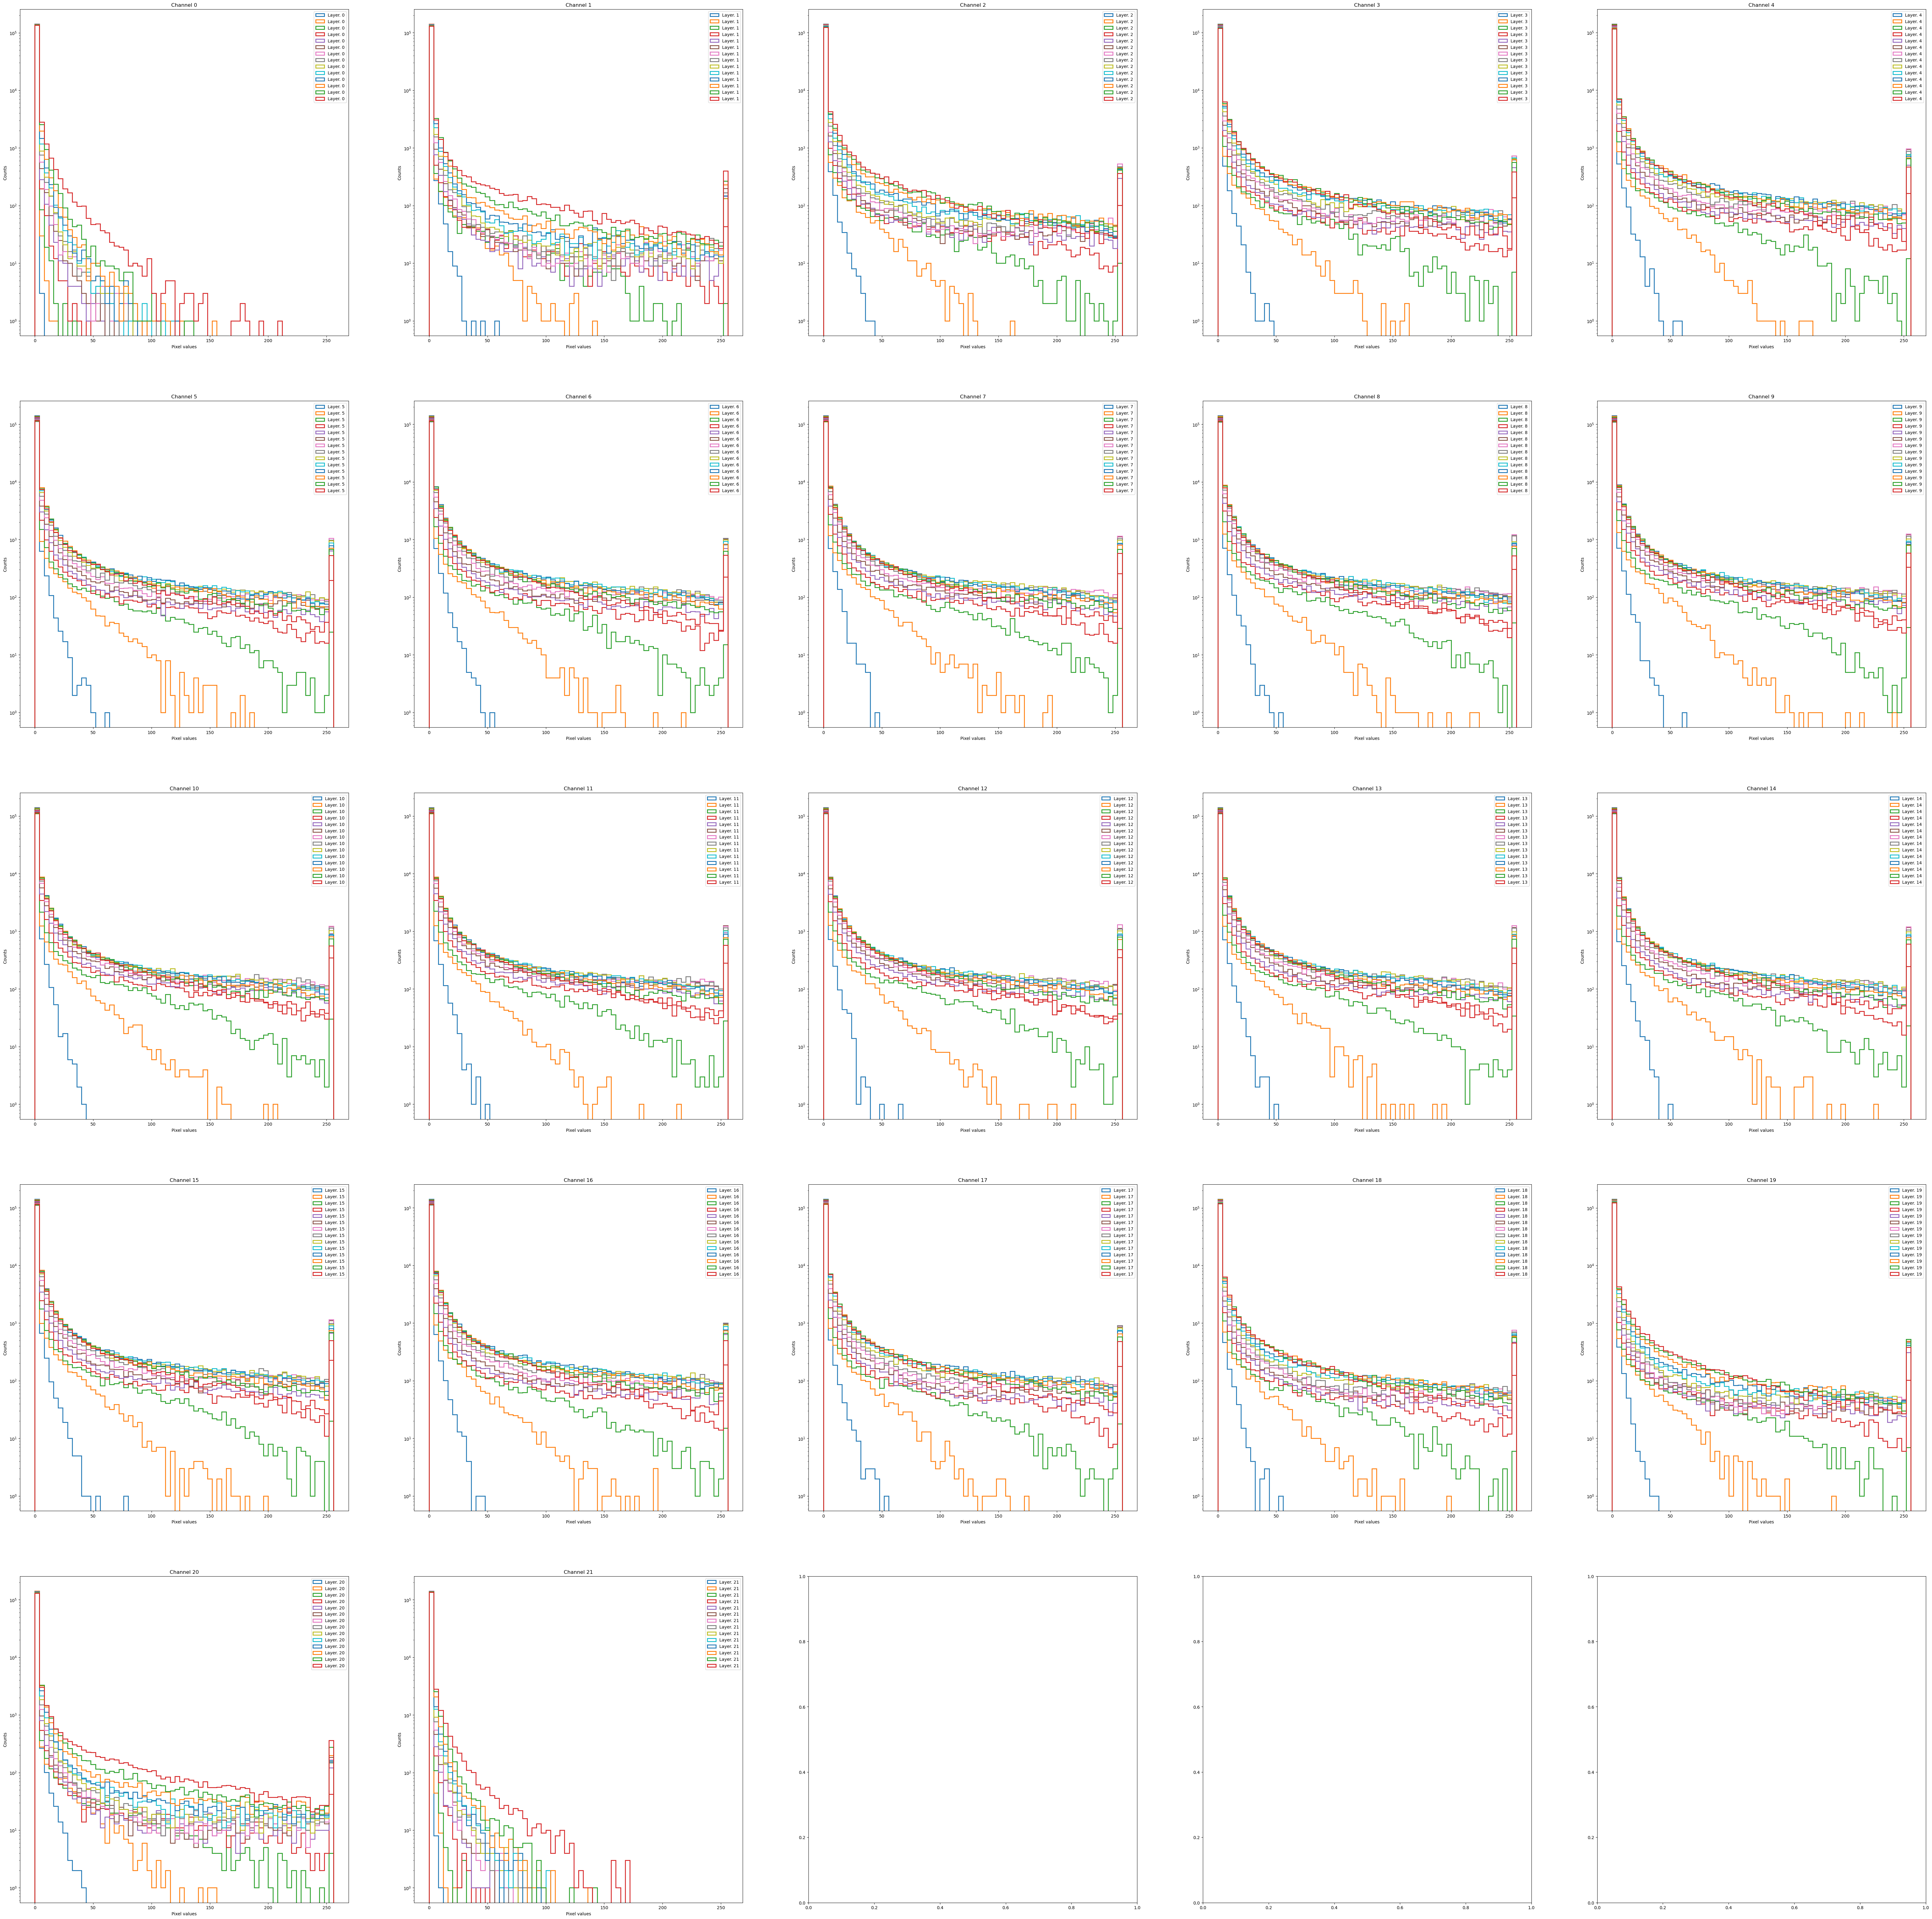

In [17]:
fig, _ = plt.subplots(5,5, figsize=(80,80))
axes = fig.axes

for i_channel in range(N_CHANNELS):
    for i_layer in range(N_LAYERS):
        axes[i_channel].hist(pixel_density[:,i_layer,i_channel], 
                           bins=np.linspace(0,256,65), 
                           histtype="step", 
                           linewidth=2, 
                           label=f"Layer. {i_channel}")
        
    axes[i_channel].set_xlabel("Pixel values")
    axes[i_channel].set_ylabel("Counts")
    axes[i_channel].set_title(f"Channel {i_channel}")
    axes[i_channel].semilogy()
    axes[i_channel].legend()
plt.show()
fig.clf()

In the above set of plots, we are looking at the distribution of pixel values for a channel across all the 14 layers. As we expect the distributions are quite similar except for layers 0 & 1. Since these are the first couple of layers, the incoming particle does not deposit all of its energy here so we have a cutoff to the pixel distributions.

### Let's look at the total deposited energy and the $E^{max}_{bar}$ energy

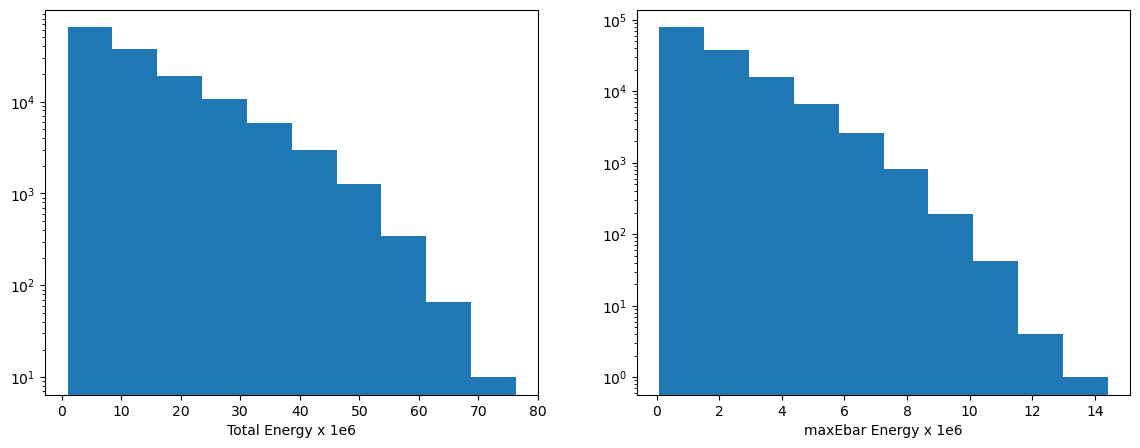

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].hist(calorimeter_data[:, 0]/1e6)
ax[0].set_xlabel('Total Energy x 1e6')
ax[0].semilogy()
ax[1].hist(calorimeter_data[:, 1]/1e6)
ax[1].set_xlabel('maxEbar Energy x 1e6')
ax[1].semilogy()
plt.show()

## Let's look at the distribution of the truth x,y hits

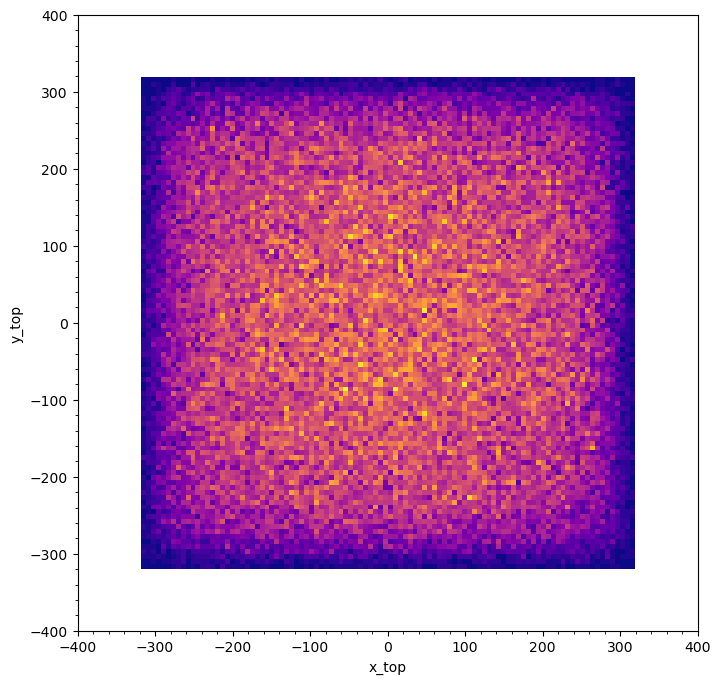

In [19]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist2d(data_target[:, 1], data_target[:, 3], bins=100, cmap='plasma')
ax.set_xlim(-400,400)
ax.set_ylim(-400,400)
ax.set_xlabel('x_top')
ax.set_ylabel('y_top')
plt.minorticks_on()

plt.show()

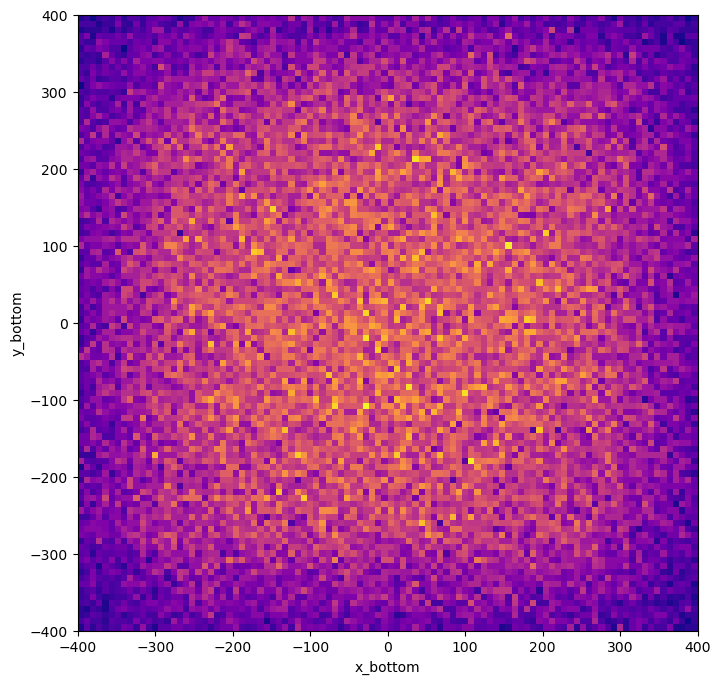

In [20]:
fix, ax = plt.subplots(figsize=(8,8))

ax.hist2d(data_target[:, 0], data_target[:, 2], bins=100, cmap='plasma')
ax.set_xlim(-400,400)
ax.set_ylim(-400,400)
ax.set_xlabel('x_bottom')
ax.set_ylabel('y_bottom')

plt.show()

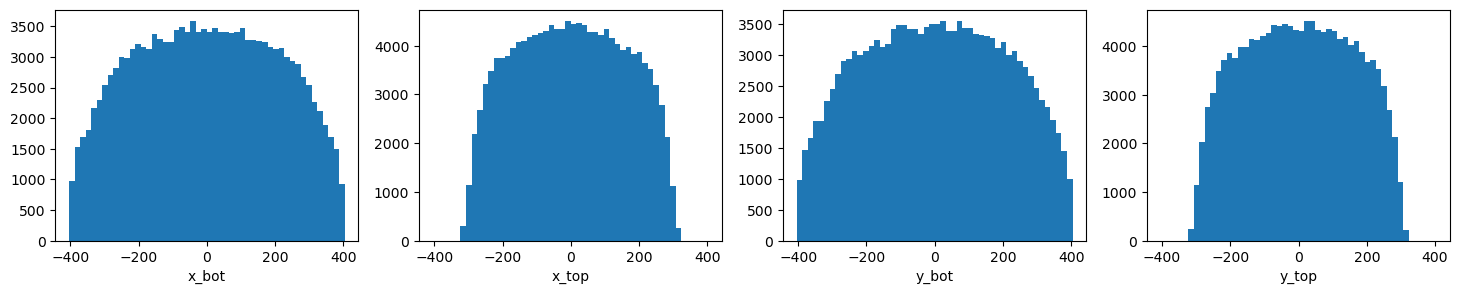

In [21]:
n_c = 1
n_r = 4
fig, axes = plt.subplots(n_c, n_r, figsize=(18, 3))
names = ['x_bot', 'x_top', 'y_bot', 'y_top']
for i, ax in enumerate(fig.axes):
    ax.hist(data_target[:, i], bins=np.linspace(-404,404,51))
    ax.set_xlabel(names[i])
#     ax.semilogy()
plt.show()

## Data preprocessing

For the data preprocessing let's start by scaling the images and the energy values to map in the range [0,1]. I suppose we would need to perform more sophisticated engineering such as adding noise, rotating the images, etc.

In [22]:
import preprocess

### Scale the calorimeter images

In [ ]:
# scaled_images = (calorimeter_images[:,:,:,0] - calorimeter_images.min(axis=0)[:,:,0]) / (calorimeter_images.max(axis=0)[:,:,0] - calorimeter_images.min(axis=0)[:,:,0])

In [ ]:
# scaled_images_reshaped = np.reshape(scaled_images, newshape=(scaled_images.shape[0], scaled_images.shape[1], scaled_images.shape[2], 1))

# print(f"After scaling and reshaping, the new array has dimensions {scaled_images_reshaped.shape}")
# print(f"Original array shape {calorimeter_images.shape}")

In [23]:
scaled_images_minmax = preprocess.preprocess_images(calorimeter_images, scale_type="minmax")

In [24]:
scaled_images_minmax[0].shape

(14, 22, 1)

### Plot the sum pixel hits after preprocessing

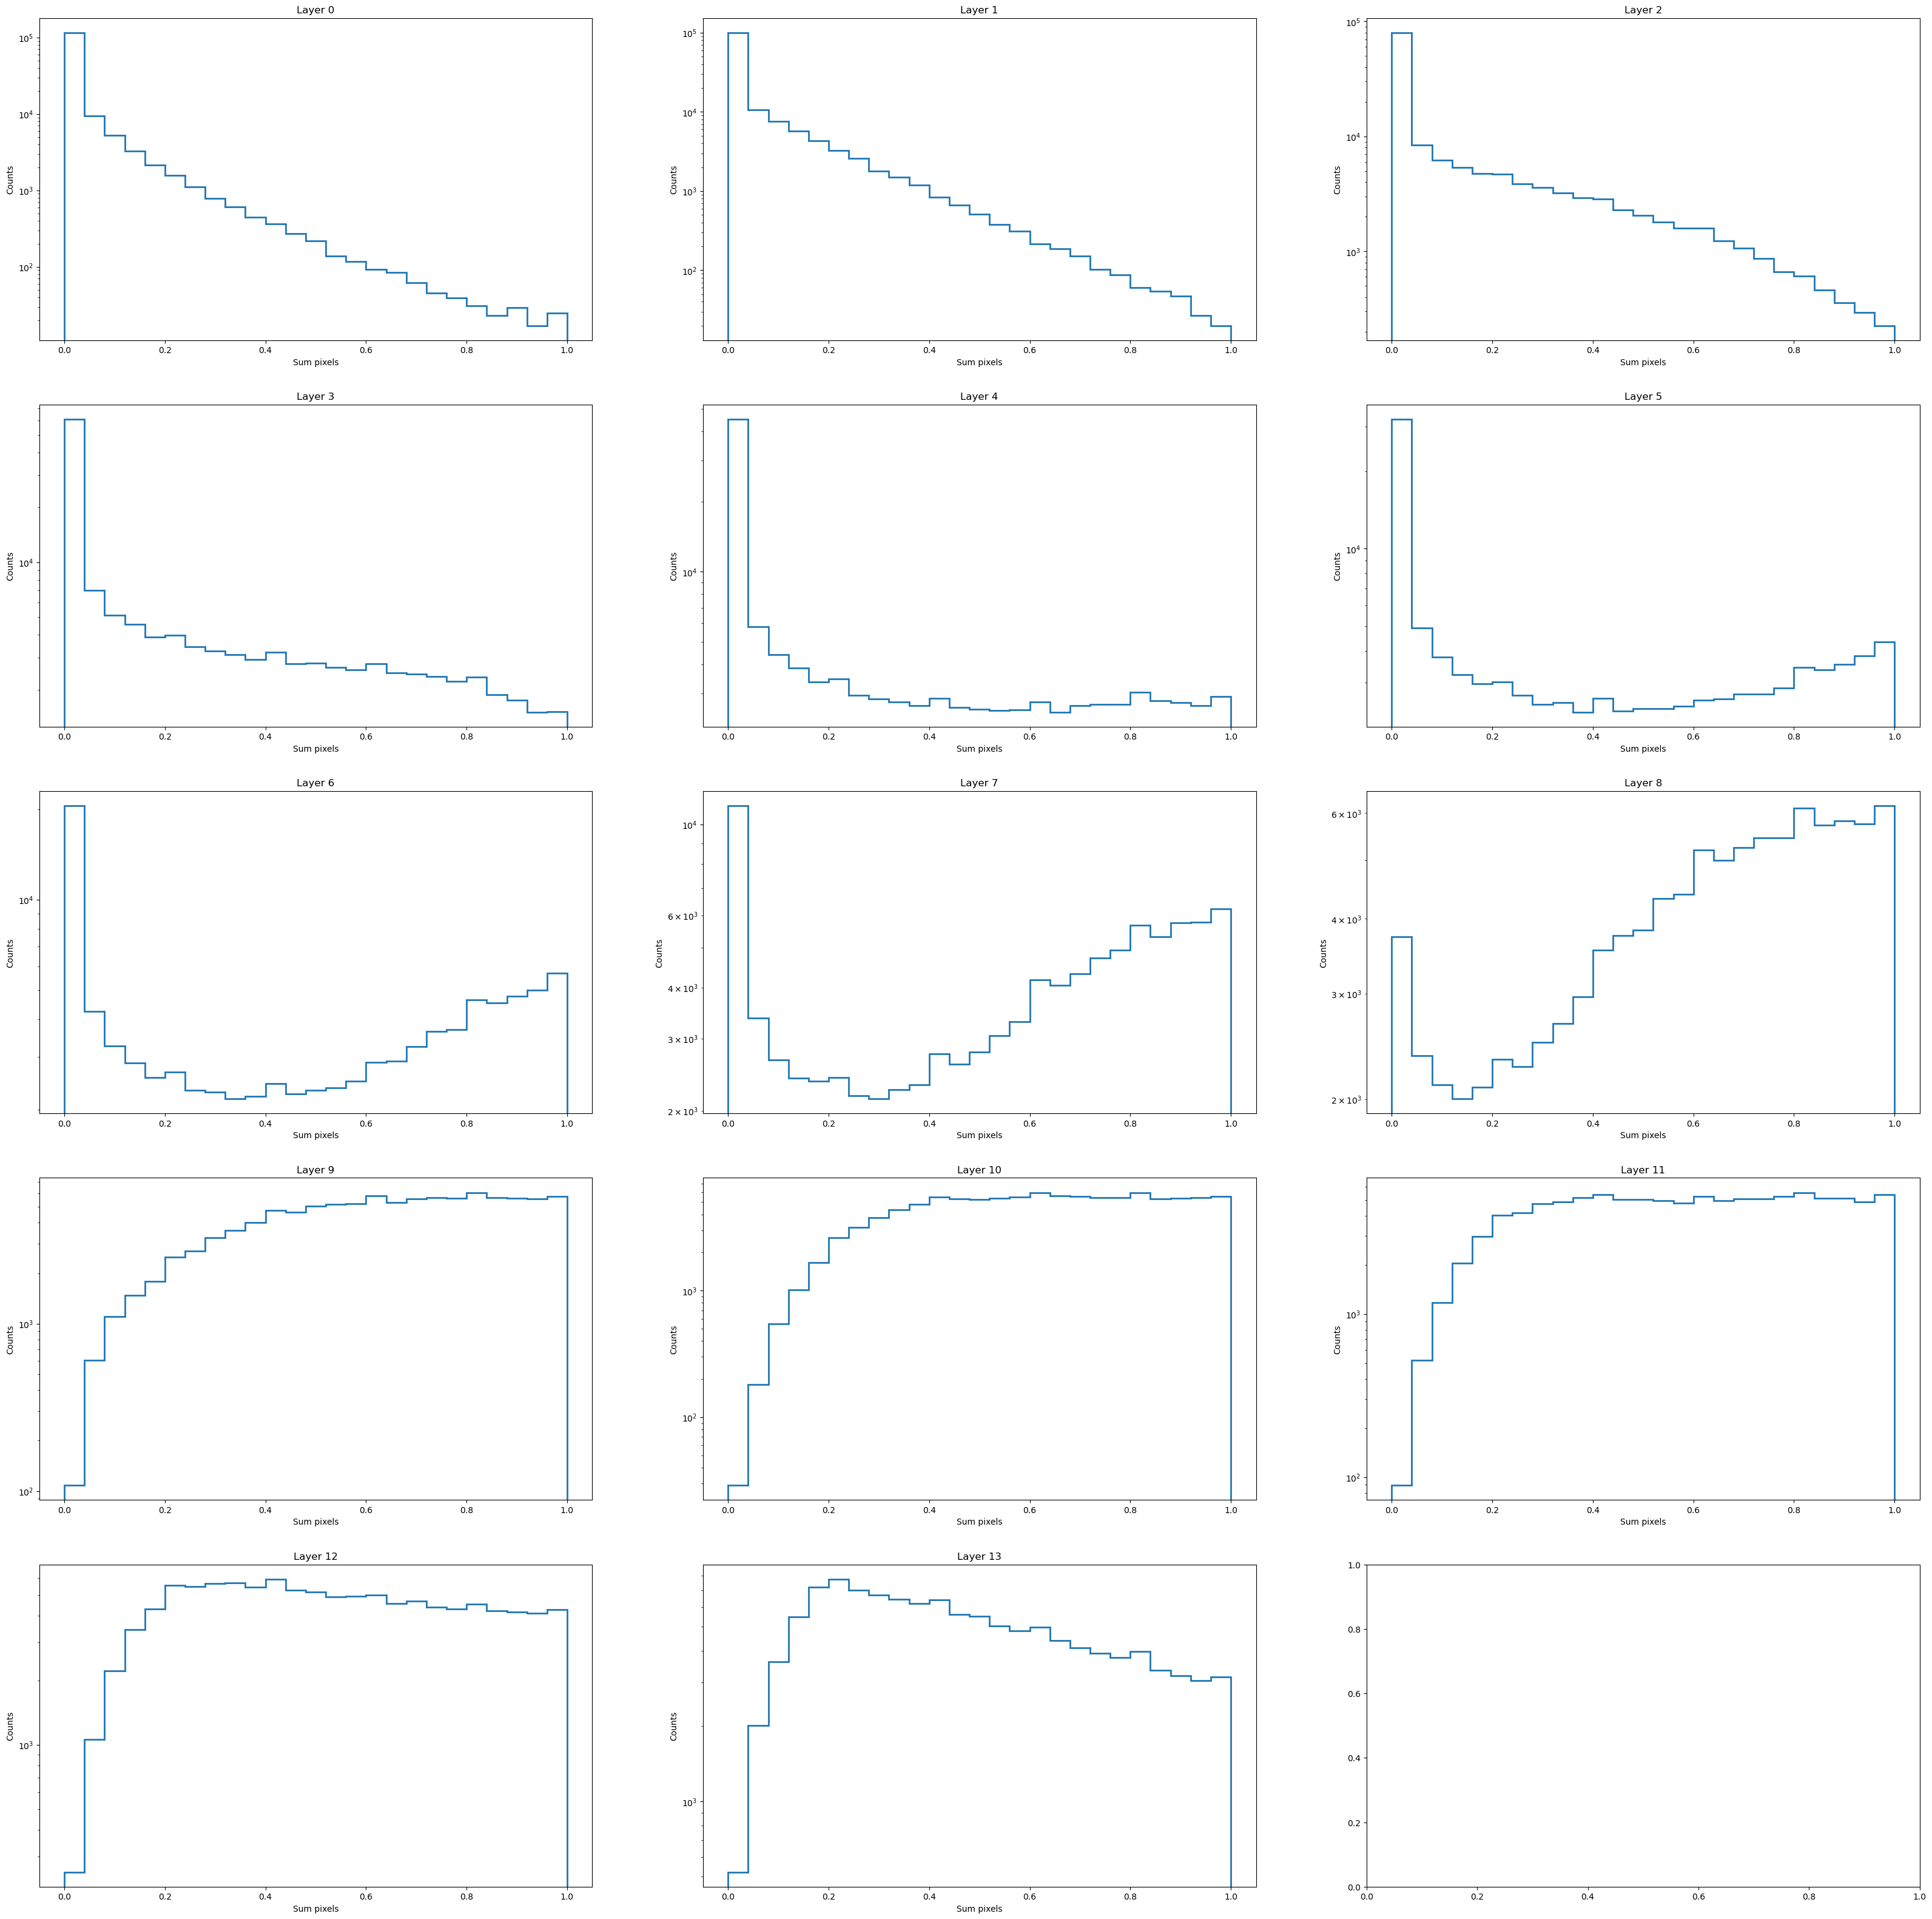

In [25]:
pixel_density = scaled_images_minmax[:,:,:,0]

sum_pixels_layer = pixel_density.sum(axis=2)

fig, _ = plt.subplots(5,3, figsize=(40,40))
axes = fig.axes

for i_layer in range(N_LAYERS):
    axes[i_layer].hist(sum_pixels_layer[:,i_layer], bins=np.linspace(0,1,26), histtype='step', linewidth=2)
    axes[i_layer].set_title(f"Layer {i_layer}")
    axes[i_layer].set_xlabel("Sum pixels")
    axes[i_layer].set_ylabel("Counts")
    axes[i_layer].semilogy()

plt.show()
fig.clf()

### Scale the energies

In [26]:
calorimeter_data_scaled = preprocess.preprocess_data(calorimeter_data)

### Scale the truth (x,y) co-ordinates

In [27]:
data_target_scaled = preprocess.preprocess_data(data_target, feature_range=(-1,1))
data_rec_scaled    = preprocess.preprocess_data(data_rec, feature_range=(-1,1))

### Compare the reconstructed and the predicted x-y co-ordinates

In [28]:
import plotting

/Users/devanshu/UniGe/final-project-dampe/plotting.py:158: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.85, 0.8, f"$\mu$ = {popt[1]:0.3f}",
/Users/devanshu/UniGe/final-project-dampe/plotting.py:161: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.85, 0.75, f"$\sigma$ = {popt[2]:0.3f}",


In [29]:
plotting.make_pretty_format()

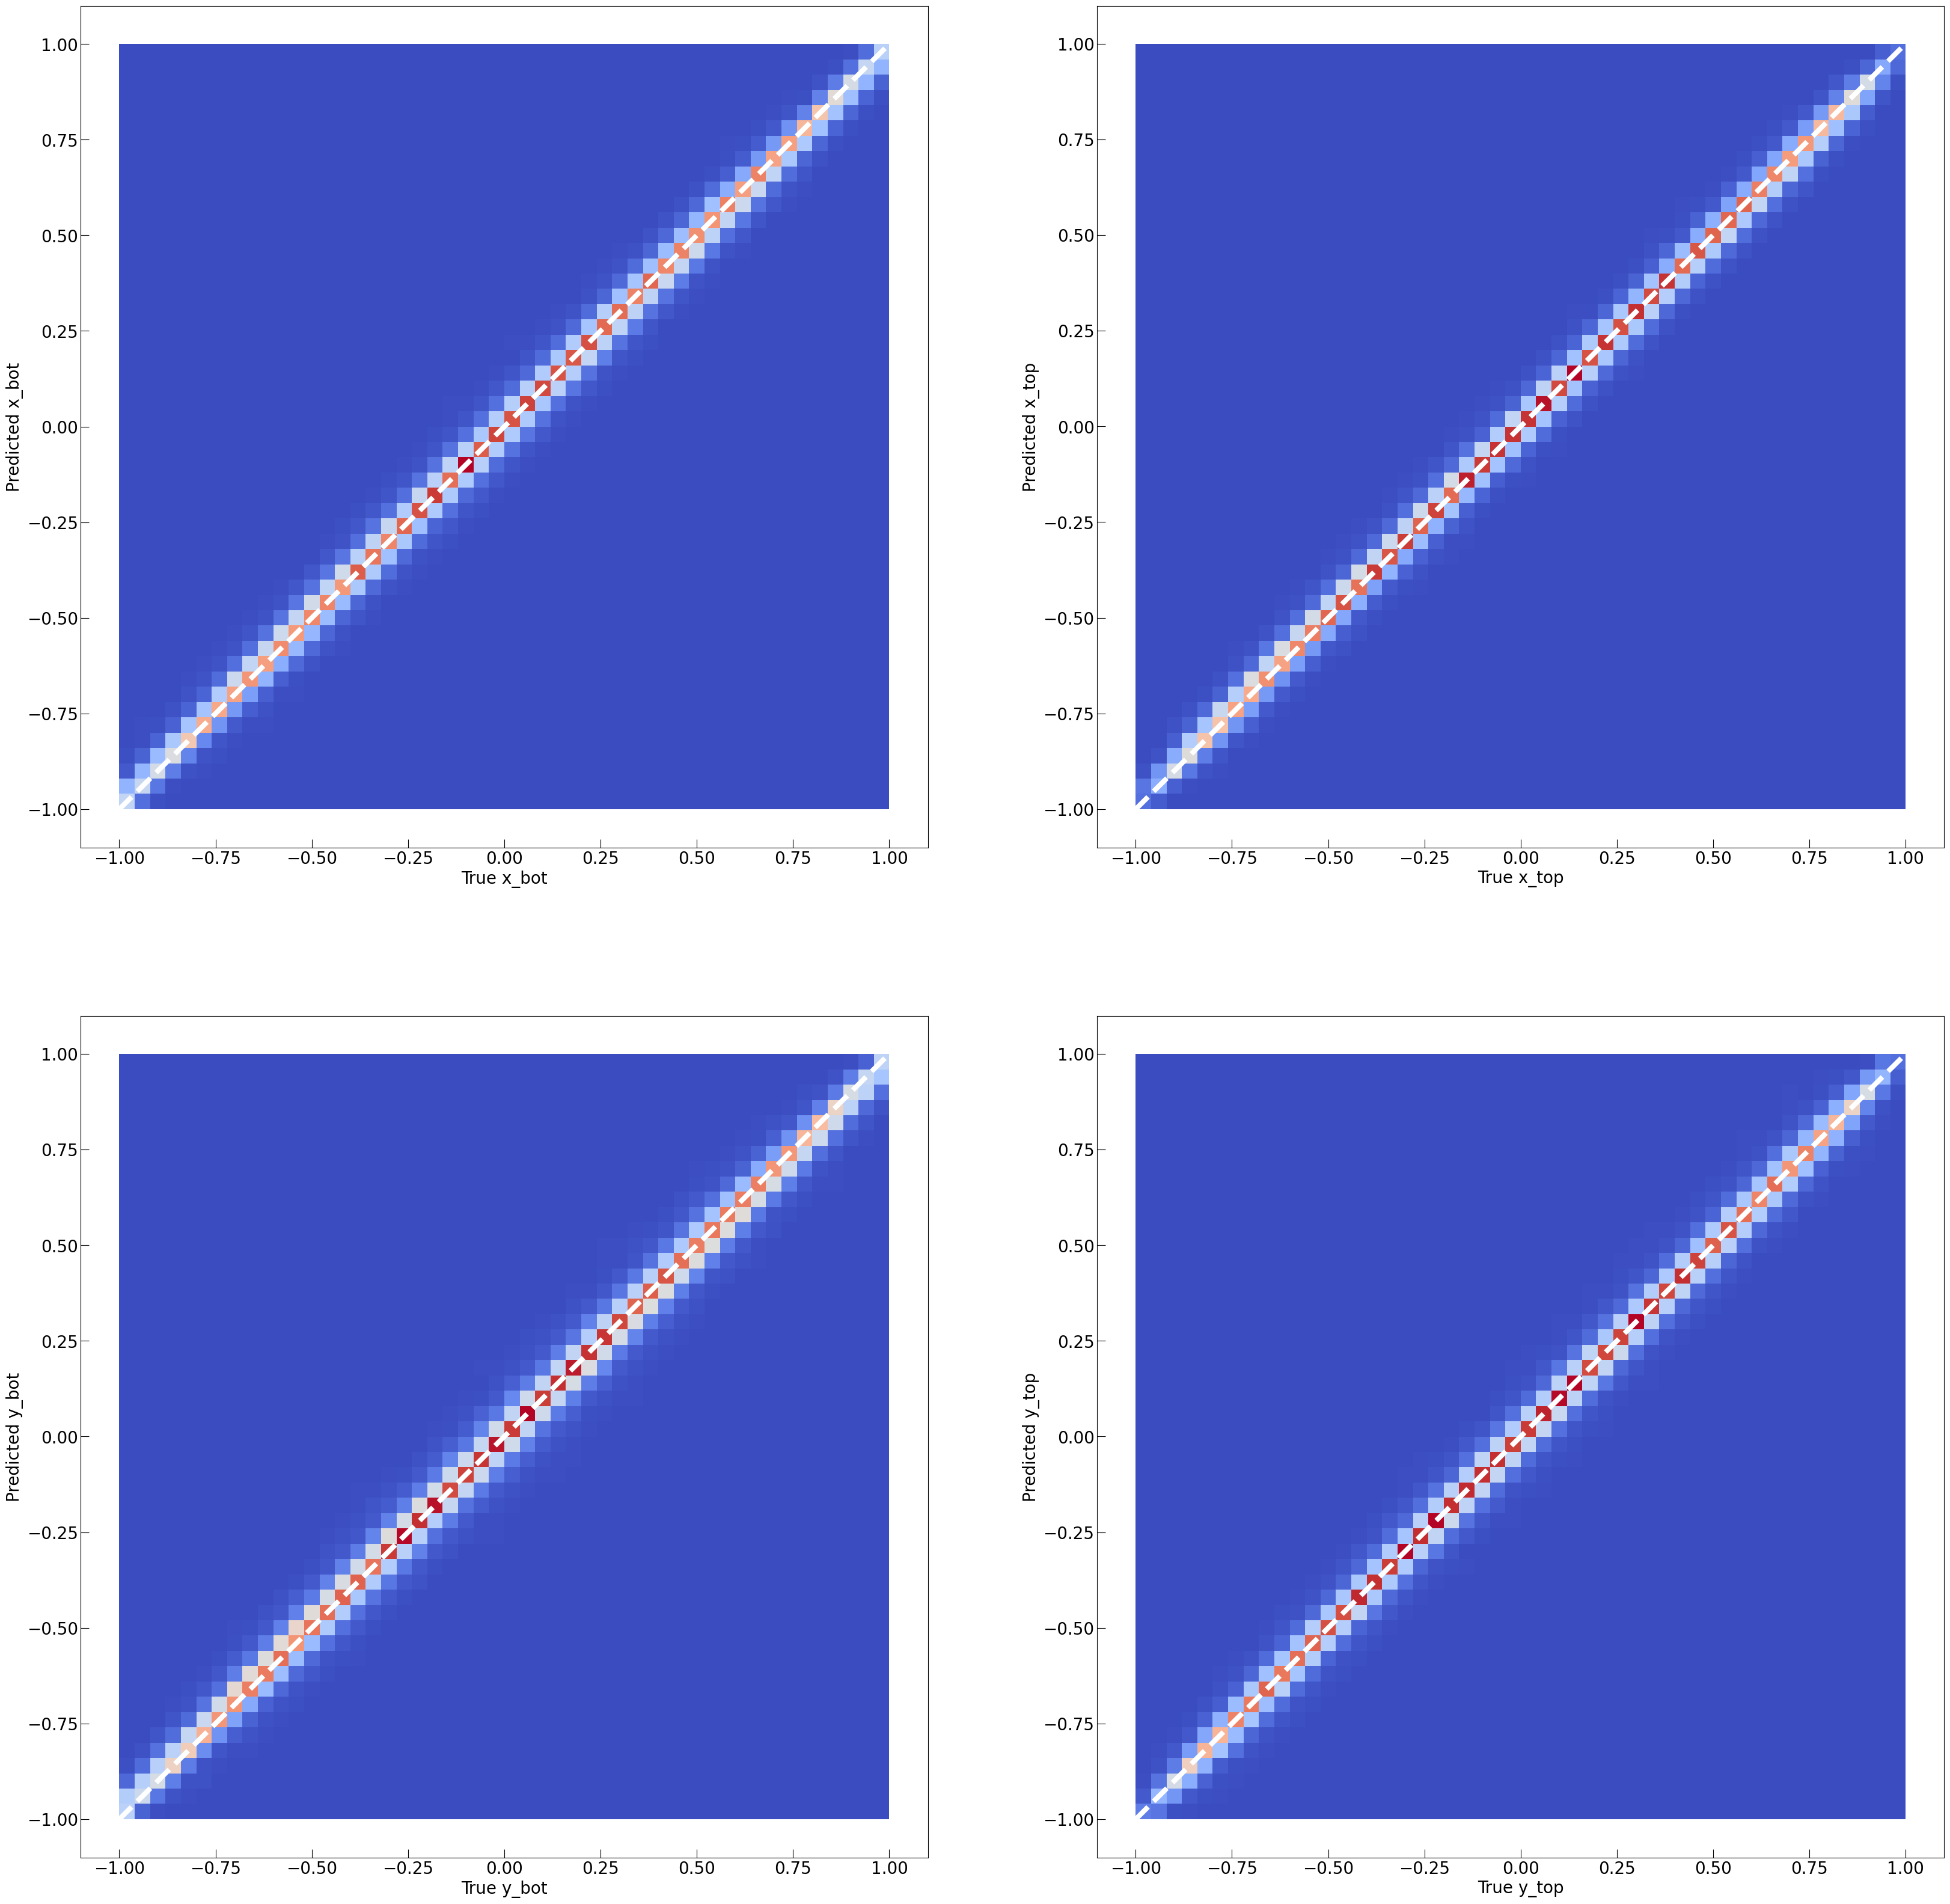

In [30]:
fig = plotting.plot_predictions(data_rec_scaled, data_target_scaled, var_label=names)

plt.show()

/Users/devanshu/UniGe/final-project-dampe/plotting.py:19: RuntimeWarning: invalid value encountered in sqrt
  return (A / np.sqrt(sigma)) * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))


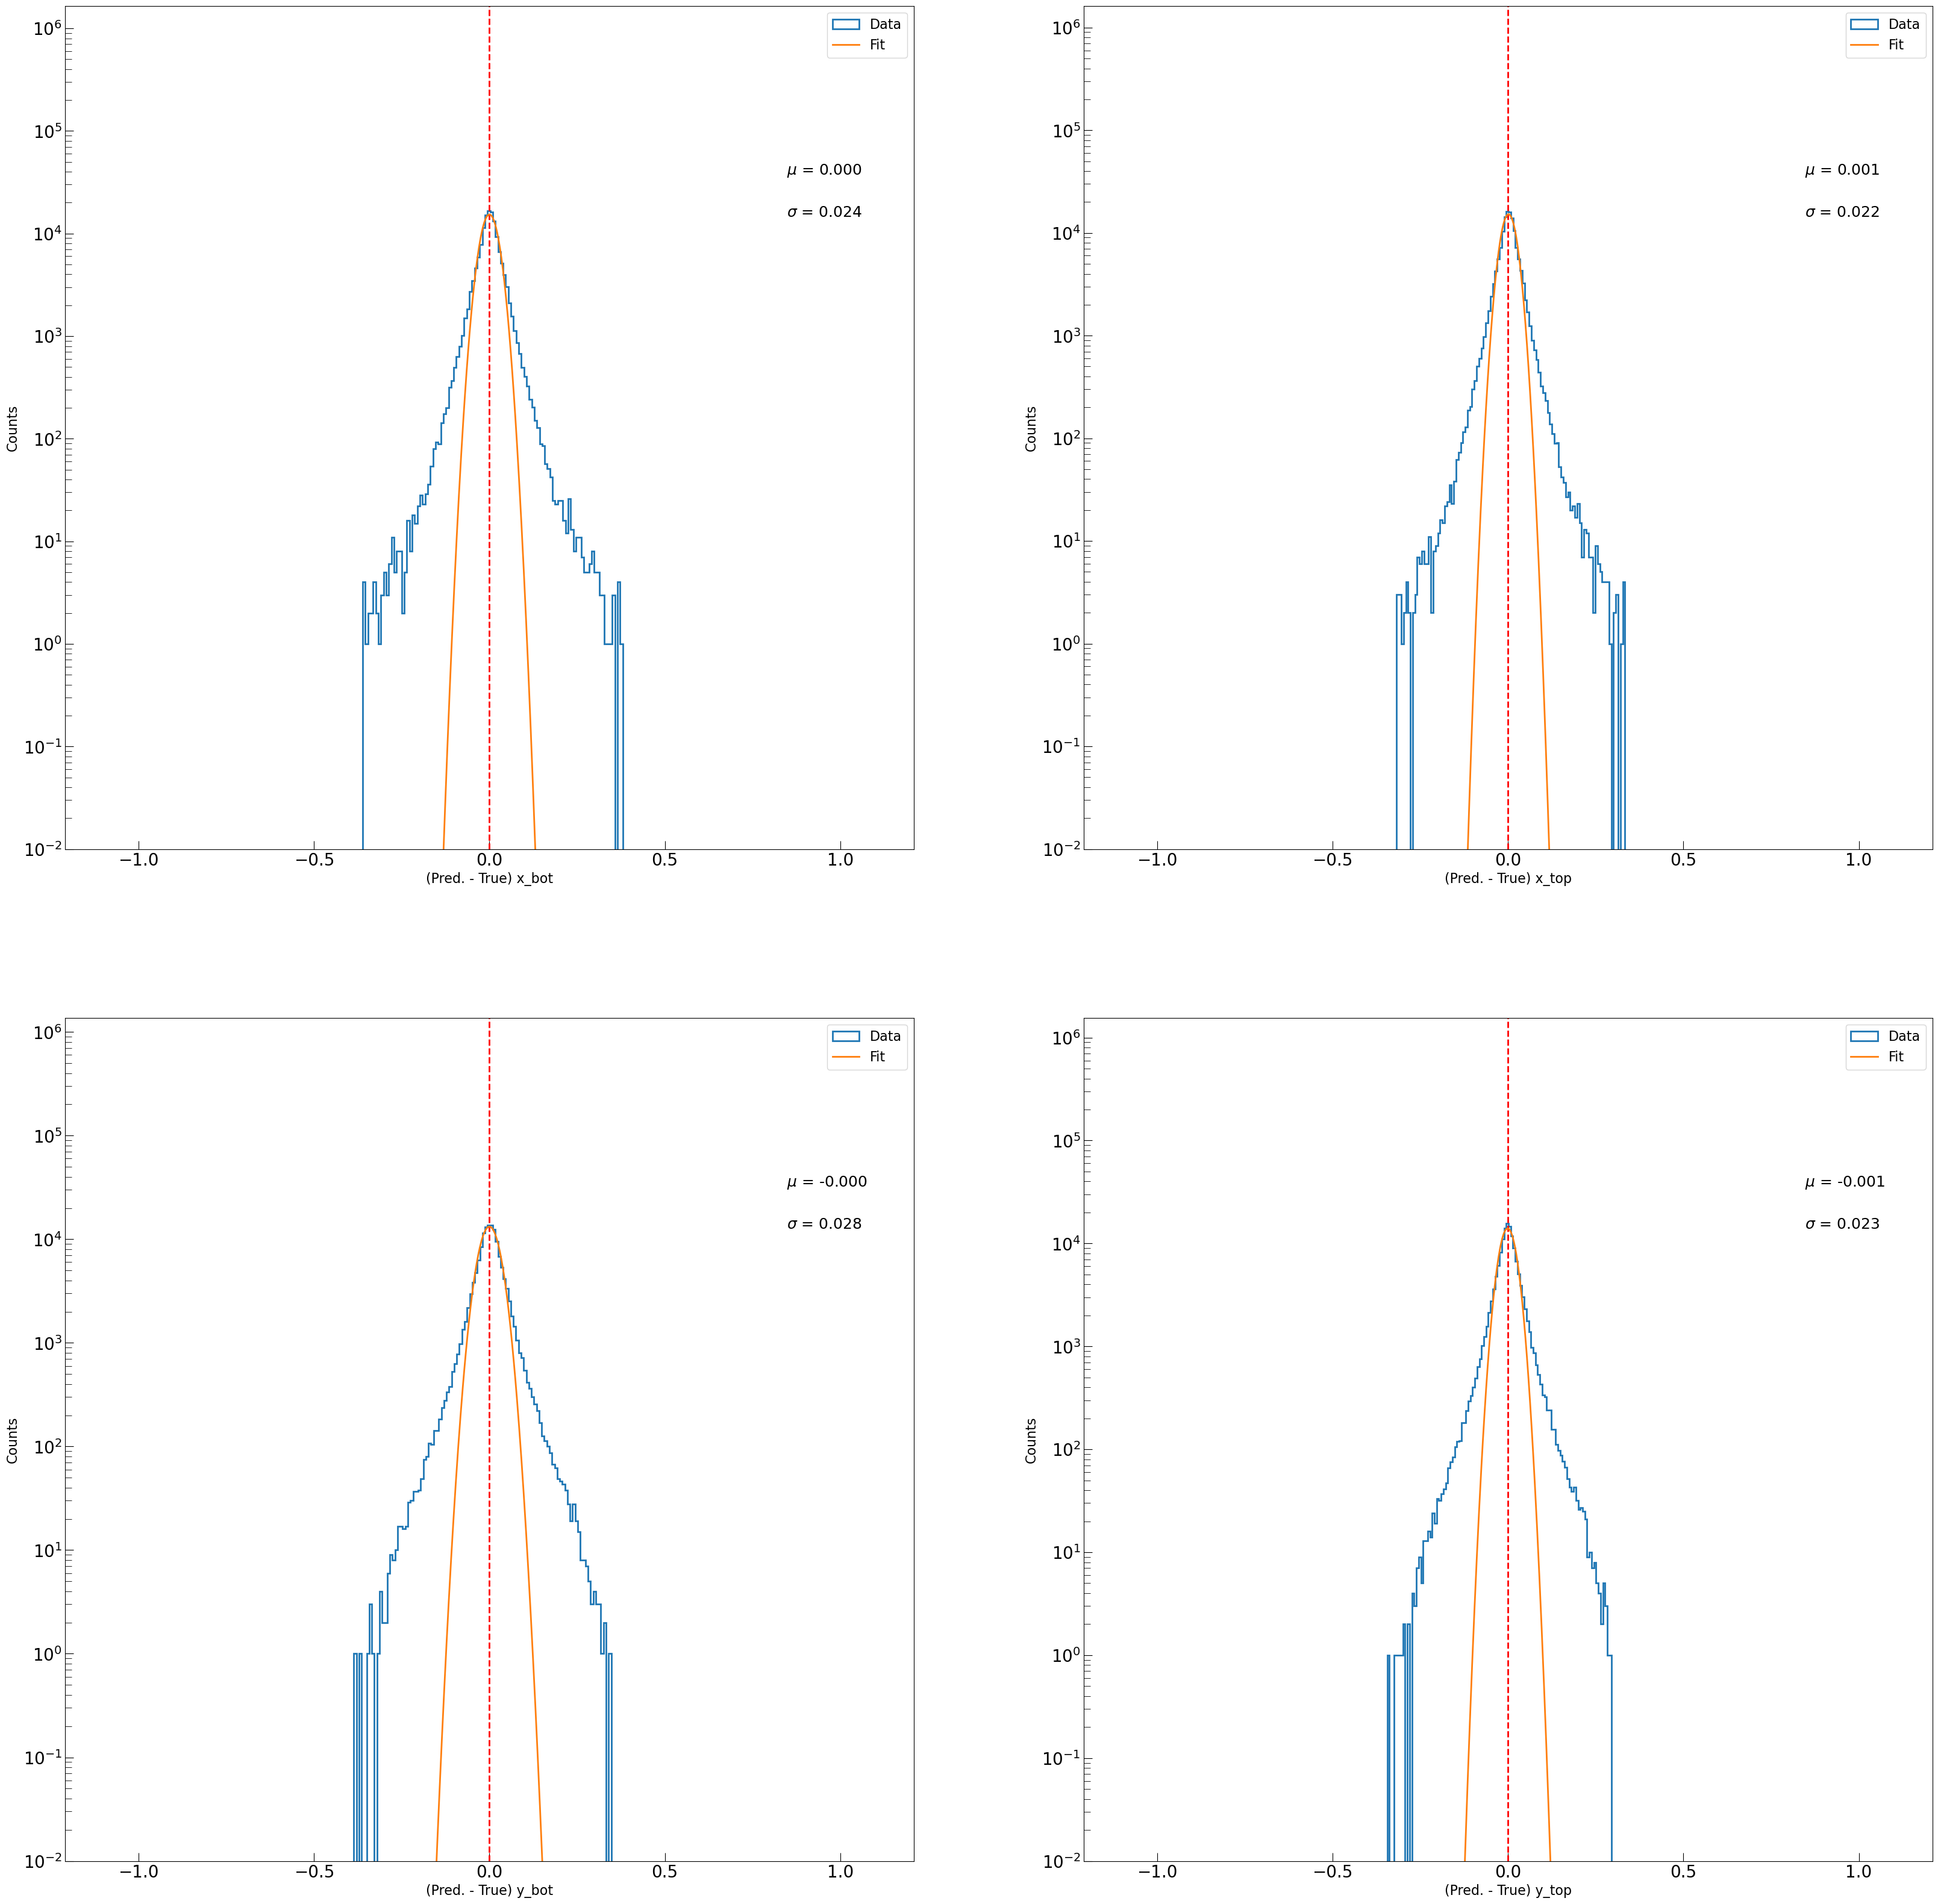

In [31]:
fig = plotting.plot_bias(data_rec_scaled, data_target_scaled, var_label=names, fit_bias=True)

plt.show()

## Save the preprocessed data

In [32]:
np.savez("data/preprocessed_scaled_data_v2.npz", scaled_images_minmax, calorimeter_data_scaled, data_target_scaled)